<h1>Table des matières<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Importation-des-bibliothèques" data-toc-modified-id="Importation-des-bibliothèques-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Importation des bibliothèques</a></span></li><li><span><a href="#Jeu-de-données" data-toc-modified-id="Jeu-de-données-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Jeu de données</a></span></li><li><span><a href="#Prétraitement-des-données" data-toc-modified-id="Prétraitement-des-données-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Prétraitement des données</a></span><ul class="toc-item"><li><span><a href="#Lemmatisation" data-toc-modified-id="Lemmatisation-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Lemmatisation</a></span></li><li><span><a href="#Stemming" data-toc-modified-id="Stemming-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Stemming</a></span></li></ul></li><li><span><a href="#Tokenisation" data-toc-modified-id="Tokenisation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Tokenisation</a></span></li><li><span><a href="#Plongement-de-mot-(Word-Embedding)" data-toc-modified-id="Plongement-de-mot-(Word-Embedding)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Plongement de mot (Word Embedding)</a></span><ul class="toc-item"><li><span><a href="#Glove" data-toc-modified-id="Glove-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Glove</a></span></li><li><span><a href="#Word2Vec" data-toc-modified-id="Word2Vec-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Word2Vec</a></span></li></ul></li><li><span><a href="#Baseline-SimpleRNN-+-GloVe" data-toc-modified-id="Baseline-SimpleRNN-+-GloVe-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Baseline SimpleRNN + GloVe</a></span><ul class="toc-item"><li><span><a href="#Baseline-:-RNN-+-Glove" data-toc-modified-id="Baseline-:-RNN-+-Glove-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Baseline : RNN + Glove</a></span><ul class="toc-item"><li><span><a href="#Entrainement-du-modèle" data-toc-modified-id="Entrainement-du-modèle-6.1.1"><span class="toc-item-num">6.1.1&nbsp;&nbsp;</span>Entrainement du modèle</a></span></li><li><span><a href="#Évaluation-du-modèle" data-toc-modified-id="Évaluation-du-modèle-6.1.2"><span class="toc-item-num">6.1.2&nbsp;&nbsp;</span>Évaluation du modèle</a></span></li><li><span><a href="#Visualisation-de-l'apprentissage" data-toc-modified-id="Visualisation-de-l'apprentissage-6.1.3"><span class="toc-item-num">6.1.3&nbsp;&nbsp;</span>Visualisation de l'apprentissage</a></span></li><li><span><a href="#Matrice-de-confusion" data-toc-modified-id="Matrice-de-confusion-6.1.4"><span class="toc-item-num">6.1.4&nbsp;&nbsp;</span>Matrice de confusion</a></span></li><li><span><a href="#Sauvegarde-des-résultats-dans-un-tableau" data-toc-modified-id="Sauvegarde-des-résultats-dans-un-tableau-6.1.5"><span class="toc-item-num">6.1.5&nbsp;&nbsp;</span>Sauvegarde des résultats dans un tableau</a></span></li></ul></li><li><span><a href="#Baseline-:-RNN-+-Glove-+-lemma" data-toc-modified-id="Baseline-:-RNN-+-Glove-+-lemma-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Baseline : RNN + Glove + lemma</a></span><ul class="toc-item"><li><span><a href="#Entrainement-du-modèle" data-toc-modified-id="Entrainement-du-modèle-6.2.1"><span class="toc-item-num">6.2.1&nbsp;&nbsp;</span>Entrainement du modèle</a></span></li><li><span><a href="#Évaluation-du-modèle" data-toc-modified-id="Évaluation-du-modèle-6.2.2"><span class="toc-item-num">6.2.2&nbsp;&nbsp;</span>Évaluation du modèle</a></span></li><li><span><a href="#Visualisation-de-l'apprentissage" data-toc-modified-id="Visualisation-de-l'apprentissage-6.2.3"><span class="toc-item-num">6.2.3&nbsp;&nbsp;</span>Visualisation de l'apprentissage</a></span></li><li><span><a href="#Matrice-de-confusion" data-toc-modified-id="Matrice-de-confusion-6.2.4"><span class="toc-item-num">6.2.4&nbsp;&nbsp;</span>Matrice de confusion</a></span></li><li><span><a href="#Sauvegarde-des-résultats-dans-un-tableau" data-toc-modified-id="Sauvegarde-des-résultats-dans-un-tableau-6.2.5"><span class="toc-item-num">6.2.5&nbsp;&nbsp;</span>Sauvegarde des résultats dans un tableau</a></span></li></ul></li><li><span><a href="#Baseline-:-RNN-+-Glove-+-stem" data-toc-modified-id="Baseline-:-RNN-+-Glove-+-stem-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Baseline : RNN + Glove + stem</a></span><ul class="toc-item"><li><span><a href="#Entrainement-du-modèle" data-toc-modified-id="Entrainement-du-modèle-6.3.1"><span class="toc-item-num">6.3.1&nbsp;&nbsp;</span>Entrainement du modèle</a></span></li><li><span><a href="#Évaluation-du-modèle" data-toc-modified-id="Évaluation-du-modèle-6.3.2"><span class="toc-item-num">6.3.2&nbsp;&nbsp;</span>Évaluation du modèle</a></span></li><li><span><a href="#Visualisation-de-l'apprentissage" data-toc-modified-id="Visualisation-de-l'apprentissage-6.3.3"><span class="toc-item-num">6.3.3&nbsp;&nbsp;</span>Visualisation de l'apprentissage</a></span></li><li><span><a href="#Matrice-de-confusion" data-toc-modified-id="Matrice-de-confusion-6.3.4"><span class="toc-item-num">6.3.4&nbsp;&nbsp;</span>Matrice de confusion</a></span></li><li><span><a href="#Sauvegarde-des-résultats-dans-un-tableau" data-toc-modified-id="Sauvegarde-des-résultats-dans-un-tableau-6.3.5"><span class="toc-item-num">6.3.5&nbsp;&nbsp;</span>Sauvegarde des résultats dans un tableau</a></span></li></ul></li></ul></li><li><span><a href="#Baseline-SimpleRNN-+-Word2Vec" data-toc-modified-id="Baseline-SimpleRNN-+-Word2Vec-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Baseline SimpleRNN + Word2Vec</a></span><ul class="toc-item"><li><span><a href="#Baseline-SimpleRNN-+-Word2Vec" data-toc-modified-id="Baseline-SimpleRNN-+-Word2Vec-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Baseline SimpleRNN + Word2Vec</a></span><ul class="toc-item"><li><span><a href="#Entrainement-du-modèle" data-toc-modified-id="Entrainement-du-modèle-7.1.1"><span class="toc-item-num">7.1.1&nbsp;&nbsp;</span>Entrainement du modèle</a></span></li><li><span><a href="#Évaluation-du-modèle" data-toc-modified-id="Évaluation-du-modèle-7.1.2"><span class="toc-item-num">7.1.2&nbsp;&nbsp;</span>Évaluation du modèle</a></span></li><li><span><a href="#Visualisation-de-l'apprentissage" data-toc-modified-id="Visualisation-de-l'apprentissage-7.1.3"><span class="toc-item-num">7.1.3&nbsp;&nbsp;</span>Visualisation de l'apprentissage</a></span></li><li><span><a href="#Matrice-de-confusion" data-toc-modified-id="Matrice-de-confusion-7.1.4"><span class="toc-item-num">7.1.4&nbsp;&nbsp;</span>Matrice de confusion</a></span></li><li><span><a href="#Sauvegarde-des-résultats-dans-un-tableau" data-toc-modified-id="Sauvegarde-des-résultats-dans-un-tableau-7.1.5"><span class="toc-item-num">7.1.5&nbsp;&nbsp;</span>Sauvegarde des résultats dans un tableau</a></span></li></ul></li><li><span><a href="#Baseline-SimpleRNN-+-Word2Vec-+-lemma" data-toc-modified-id="Baseline-SimpleRNN-+-Word2Vec-+-lemma-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Baseline SimpleRNN + Word2Vec + lemma</a></span><ul class="toc-item"><li><span><a href="#Entrainement-du-modèle" data-toc-modified-id="Entrainement-du-modèle-7.2.1"><span class="toc-item-num">7.2.1&nbsp;&nbsp;</span>Entrainement du modèle</a></span></li><li><span><a href="#Évaluation-du-modèle" data-toc-modified-id="Évaluation-du-modèle-7.2.2"><span class="toc-item-num">7.2.2&nbsp;&nbsp;</span>Évaluation du modèle</a></span></li><li><span><a href="#Visualisation-de-l'apprentissage" data-toc-modified-id="Visualisation-de-l'apprentissage-7.2.3"><span class="toc-item-num">7.2.3&nbsp;&nbsp;</span>Visualisation de l'apprentissage</a></span></li><li><span><a href="#Matrice-de-confusion" data-toc-modified-id="Matrice-de-confusion-7.2.4"><span class="toc-item-num">7.2.4&nbsp;&nbsp;</span>Matrice de confusion</a></span></li><li><span><a href="#Sauvegarde-des-résultats-dans-un-tableau" data-toc-modified-id="Sauvegarde-des-résultats-dans-un-tableau-7.2.5"><span class="toc-item-num">7.2.5&nbsp;&nbsp;</span>Sauvegarde des résultats dans un tableau</a></span></li></ul></li><li><span><a href="#Baseline-SimpleRNN-+-Word2Vec-+-stem" data-toc-modified-id="Baseline-SimpleRNN-+-Word2Vec-+-stem-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Baseline SimpleRNN + Word2Vec + stem</a></span><ul class="toc-item"><li><span><a href="#Entrainement-du-modèle" data-toc-modified-id="Entrainement-du-modèle-7.3.1"><span class="toc-item-num">7.3.1&nbsp;&nbsp;</span>Entrainement du modèle</a></span></li><li><span><a href="#Évaluation-du-modèle" data-toc-modified-id="Évaluation-du-modèle-7.3.2"><span class="toc-item-num">7.3.2&nbsp;&nbsp;</span>Évaluation du modèle</a></span></li><li><span><a href="#Visualisation-de-l'apprentissage" data-toc-modified-id="Visualisation-de-l'apprentissage-7.3.3"><span class="toc-item-num">7.3.3&nbsp;&nbsp;</span>Visualisation de l'apprentissage</a></span></li><li><span><a href="#Matrice-de-confusion" data-toc-modified-id="Matrice-de-confusion-7.3.4"><span class="toc-item-num">7.3.4&nbsp;&nbsp;</span>Matrice de confusion</a></span></li><li><span><a href="#Sauvegarde-des-résultats-dans-un-tableau" data-toc-modified-id="Sauvegarde-des-résultats-dans-un-tableau-7.3.5"><span class="toc-item-num">7.3.5&nbsp;&nbsp;</span>Sauvegarde des résultats dans un tableau</a></span></li></ul></li></ul></li><li><span><a href="#LSTM-+-Glove" data-toc-modified-id="LSTM-+-Glove-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>LSTM + Glove</a></span><ul class="toc-item"><li><span><a href="#LSTM-+-Glove" data-toc-modified-id="LSTM-+-Glove-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>LSTM + Glove</a></span><ul class="toc-item"><li><span><a href="#Entrainement-du-modèle" data-toc-modified-id="Entrainement-du-modèle-8.1.1"><span class="toc-item-num">8.1.1&nbsp;&nbsp;</span>Entrainement du modèle</a></span></li><li><span><a href="#Évaluation-du-modèle" data-toc-modified-id="Évaluation-du-modèle-8.1.2"><span class="toc-item-num">8.1.2&nbsp;&nbsp;</span>Évaluation du modèle</a></span></li><li><span><a href="#Visualisation-de-l'apprentissage" data-toc-modified-id="Visualisation-de-l'apprentissage-8.1.3"><span class="toc-item-num">8.1.3&nbsp;&nbsp;</span>Visualisation de l'apprentissage</a></span></li><li><span><a href="#Matrice-de-confusion" data-toc-modified-id="Matrice-de-confusion-8.1.4"><span class="toc-item-num">8.1.4&nbsp;&nbsp;</span>Matrice de confusion</a></span></li><li><span><a href="#Sauvegarde-des-résultats-dans-un-tableau" data-toc-modified-id="Sauvegarde-des-résultats-dans-un-tableau-8.1.5"><span class="toc-item-num">8.1.5&nbsp;&nbsp;</span>Sauvegarde des résultats dans un tableau</a></span></li><li><span><a href="#Prédiction-du-modèle" data-toc-modified-id="Prédiction-du-modèle-8.1.6"><span class="toc-item-num">8.1.6&nbsp;&nbsp;</span>Prédiction du modèle</a></span></li></ul></li><li><span><a href="#LSTM-+-Glove-+-lemma" data-toc-modified-id="LSTM-+-Glove-+-lemma-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>LSTM + Glove + lemma</a></span><ul class="toc-item"><li><span><a href="#Entrainement-du-modèle" data-toc-modified-id="Entrainement-du-modèle-8.2.1"><span class="toc-item-num">8.2.1&nbsp;&nbsp;</span>Entrainement du modèle</a></span></li><li><span><a href="#Évaluation-du-modèle" data-toc-modified-id="Évaluation-du-modèle-8.2.2"><span class="toc-item-num">8.2.2&nbsp;&nbsp;</span>Évaluation du modèle</a></span></li><li><span><a href="#Visualisation-de-l'apprentissage" data-toc-modified-id="Visualisation-de-l'apprentissage-8.2.3"><span class="toc-item-num">8.2.3&nbsp;&nbsp;</span>Visualisation de l'apprentissage</a></span></li><li><span><a href="#Matrice-de-confusion" data-toc-modified-id="Matrice-de-confusion-8.2.4"><span class="toc-item-num">8.2.4&nbsp;&nbsp;</span>Matrice de confusion</a></span></li><li><span><a href="#Sauvegarde-des-résultats-dans-un-tableau" data-toc-modified-id="Sauvegarde-des-résultats-dans-un-tableau-8.2.5"><span class="toc-item-num">8.2.5&nbsp;&nbsp;</span>Sauvegarde des résultats dans un tableau</a></span></li></ul></li><li><span><a href="#LSTM-+-Glove-+-stem" data-toc-modified-id="LSTM-+-Glove-+-stem-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>LSTM + Glove + stem</a></span><ul class="toc-item"><li><span><a href="#Entrainement-du-modèle" data-toc-modified-id="Entrainement-du-modèle-8.3.1"><span class="toc-item-num">8.3.1&nbsp;&nbsp;</span>Entrainement du modèle</a></span></li><li><span><a href="#Évaluation-du-modèle" data-toc-modified-id="Évaluation-du-modèle-8.3.2"><span class="toc-item-num">8.3.2&nbsp;&nbsp;</span>Évaluation du modèle</a></span></li><li><span><a href="#Visualisation-de-l'apprentissage" data-toc-modified-id="Visualisation-de-l'apprentissage-8.3.3"><span class="toc-item-num">8.3.3&nbsp;&nbsp;</span>Visualisation de l'apprentissage</a></span></li><li><span><a href="#Matrice-de-confusion" data-toc-modified-id="Matrice-de-confusion-8.3.4"><span class="toc-item-num">8.3.4&nbsp;&nbsp;</span>Matrice de confusion</a></span></li><li><span><a href="#Sauvegarde-des-résultats-dans-un-tableau" data-toc-modified-id="Sauvegarde-des-résultats-dans-un-tableau-8.3.5"><span class="toc-item-num">8.3.5&nbsp;&nbsp;</span>Sauvegarde des résultats dans un tableau</a></span></li></ul></li></ul></li><li><span><a href="#LSTM-+-Word2Vec" data-toc-modified-id="LSTM-+-Word2Vec-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>LSTM + Word2Vec</a></span><ul class="toc-item"><li><span><a href="#LSTM-+-Word2Vec" data-toc-modified-id="LSTM-+-Word2Vec-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>LSTM + Word2Vec</a></span><ul class="toc-item"><li><span><a href="#Entrainement-du-modèle" data-toc-modified-id="Entrainement-du-modèle-9.1.1"><span class="toc-item-num">9.1.1&nbsp;&nbsp;</span>Entrainement du modèle</a></span></li><li><span><a href="#Évaluation-du-modèle" data-toc-modified-id="Évaluation-du-modèle-9.1.2"><span class="toc-item-num">9.1.2&nbsp;&nbsp;</span>Évaluation du modèle</a></span></li><li><span><a href="#Visualisation-de-l'apprentissage" data-toc-modified-id="Visualisation-de-l'apprentissage-9.1.3"><span class="toc-item-num">9.1.3&nbsp;&nbsp;</span>Visualisation de l'apprentissage</a></span></li><li><span><a href="#Matrice-de-confusion" data-toc-modified-id="Matrice-de-confusion-9.1.4"><span class="toc-item-num">9.1.4&nbsp;&nbsp;</span>Matrice de confusion</a></span></li><li><span><a href="#Sauvegarde-des-résultats-dans-un-tableau" data-toc-modified-id="Sauvegarde-des-résultats-dans-un-tableau-9.1.5"><span class="toc-item-num">9.1.5&nbsp;&nbsp;</span>Sauvegarde des résultats dans un tableau</a></span></li></ul></li><li><span><a href="#LSTM-+-Word2Vec-+-lemma" data-toc-modified-id="LSTM-+-Word2Vec-+-lemma-9.2"><span class="toc-item-num">9.2&nbsp;&nbsp;</span>LSTM + Word2Vec + lemma</a></span><ul class="toc-item"><li><span><a href="#Entrainement-du-modèle" data-toc-modified-id="Entrainement-du-modèle-9.2.1"><span class="toc-item-num">9.2.1&nbsp;&nbsp;</span>Entrainement du modèle</a></span></li><li><span><a href="#Évaluation-du-modèle" data-toc-modified-id="Évaluation-du-modèle-9.2.2"><span class="toc-item-num">9.2.2&nbsp;&nbsp;</span>Évaluation du modèle</a></span></li><li><span><a href="#Visualisation-de-l'apprentissage" data-toc-modified-id="Visualisation-de-l'apprentissage-9.2.3"><span class="toc-item-num">9.2.3&nbsp;&nbsp;</span>Visualisation de l'apprentissage</a></span></li><li><span><a href="#Matrice-de-confusion" data-toc-modified-id="Matrice-de-confusion-9.2.4"><span class="toc-item-num">9.2.4&nbsp;&nbsp;</span>Matrice de confusion</a></span></li><li><span><a href="#Sauvegarde-des-résultats-dans-un-tableau" data-toc-modified-id="Sauvegarde-des-résultats-dans-un-tableau-9.2.5"><span class="toc-item-num">9.2.5&nbsp;&nbsp;</span>Sauvegarde des résultats dans un tableau</a></span></li></ul></li><li><span><a href="#LSTM-+-Word2Vec-+-stem" data-toc-modified-id="LSTM-+-Word2Vec-+-stem-9.3"><span class="toc-item-num">9.3&nbsp;&nbsp;</span>LSTM + Word2Vec + stem</a></span><ul class="toc-item"><li><span><a href="#Entrainement-du-modèle" data-toc-modified-id="Entrainement-du-modèle-9.3.1"><span class="toc-item-num">9.3.1&nbsp;&nbsp;</span>Entrainement du modèle</a></span></li><li><span><a href="#Évaluation-du-modèle" data-toc-modified-id="Évaluation-du-modèle-9.3.2"><span class="toc-item-num">9.3.2&nbsp;&nbsp;</span>Évaluation du modèle</a></span></li><li><span><a href="#Visualisation-de-l'apprentissage" data-toc-modified-id="Visualisation-de-l'apprentissage-9.3.3"><span class="toc-item-num">9.3.3&nbsp;&nbsp;</span>Visualisation de l'apprentissage</a></span></li><li><span><a href="#Matrice-de-confusion" data-toc-modified-id="Matrice-de-confusion-9.3.4"><span class="toc-item-num">9.3.4&nbsp;&nbsp;</span>Matrice de confusion</a></span></li><li><span><a href="#Sauvegarde-des-résultats-dans-un-tableau" data-toc-modified-id="Sauvegarde-des-résultats-dans-un-tableau-9.3.5"><span class="toc-item-num">9.3.5&nbsp;&nbsp;</span>Sauvegarde des résultats dans un tableau</a></span></li></ul></li></ul></li><li><span><a href="#Bonus-:-Bidirectional-LSTM" data-toc-modified-id="Bonus-:-Bidirectional-LSTM-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Bonus : Bidirectional LSTM</a></span></li><li><span><a href="#BERT" data-toc-modified-id="BERT-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>BERT</a></span><ul class="toc-item"><li><span><a href="#Entrainement-du-modèle" data-toc-modified-id="Entrainement-du-modèle-11.1"><span class="toc-item-num">11.1&nbsp;&nbsp;</span>Entrainement du modèle</a></span></li><li><span><a href="#Évaluation-du-modèle" data-toc-modified-id="Évaluation-du-modèle-11.2"><span class="toc-item-num">11.2&nbsp;&nbsp;</span>Évaluation du modèle</a></span></li><li><span><a href="#Sauvegarde-des-résultats-dans-un-tableau" data-toc-modified-id="Sauvegarde-des-résultats-dans-un-tableau-11.3"><span class="toc-item-num">11.3&nbsp;&nbsp;</span>Sauvegarde des résultats dans un tableau</a></span></li></ul></li><li><span><a href="#BERT-+-LSTM" data-toc-modified-id="BERT-+-LSTM-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>BERT + LSTM</a></span><ul class="toc-item"><li><span><a href="#Évaluation-du-modèle" data-toc-modified-id="Évaluation-du-modèle-12.1"><span class="toc-item-num">12.1&nbsp;&nbsp;</span>Évaluation du modèle</a></span></li><li><span><a href="#Sauvegarde-des-résultats-dans-un-tableau" data-toc-modified-id="Sauvegarde-des-résultats-dans-un-tableau-12.2"><span class="toc-item-num">12.2&nbsp;&nbsp;</span>Sauvegarde des résultats dans un tableau</a></span></li></ul></li><li><span><a href="#TensorBoard" data-toc-modified-id="TensorBoard-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>TensorBoard</a></span></li><li><span><a href="#Tableau-comparatif" data-toc-modified-id="Tableau-comparatif-14"><span class="toc-item-num">14&nbsp;&nbsp;</span>Tableau comparatif</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-15"><span class="toc-item-num">15&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></div>

# Outil de détection de Bad Buzz grâce au Deep Learning

![logo](data/image/logo.png "Air Paradis")

**Air Paradis** souhaite un produit IA permettant d’anticiper les bad buzz sur les réseaux sociaux. Pour cela, nous allons concevoir un PoC d’un outil d’analyse émotionnel à l’aide d’un jeu de données de tweets.

**Analyse des sentiments des tweets avec LSTM**

L’analyse des sentiments est le processus d’interprétation et de classification des émotions dans les données textuelles. Ce domaine a acquis une grande importance dans l’analyse des médias sociaux, car il permet aux entreprises d’identifier les sentiments de leurs clients envers leurs marques et leurs services. Twitter étant l’un des réseaux sociaux les plus utilisés de nos jours, l’analyse des sentiments sur Twitter est devenue une tâche importante pour classer les tweets comme négatifs, neutres ou positifs.

## Importation des bibliothèques

<img src="data/image/computer.png" width="150">

Tout d'abord, il est nécessaire d'importer toutes les bibliothèques. Certaines d'entre elles sont utilisées pour manipuler et prétraiter les données et d'autres pour construire et entraîner des modèles.

In [1]:
# Importation des modules nécessaires
import os
from datetime import datetime
import itertools

import matplotlib.pyplot as plt

from time import time

import numpy as np
from numpy import asarray
from numpy import zeros

import gensim
import pandas as pd
import pickle
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.layers import SimpleRNN, LSTM, Bidirectional
%load_ext tensorboard

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, GlobalMaxPool1D
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.callbacks import ReduceLROnPlateau
from keras.models import load_model

from transformers import logging, AutoTokenizer, TFAutoModel
from functions import * 

## Jeu de données

<img src="data/image/database.png" width="150">

Le jeu de données utilisé dans ce projet a été obtenu de Sentiment140 et il contient 1,6 million de tweets en anglais sans émoticônes. Il est important de mentionner que les polarités dans ce jeu de données de tweets ne comprennent que des étiquettes négatives et positives, ce projet est donc attaché à cette classification binaire.

Le jeu de données peut être téléchargé à l'adresse suivante : https://www.kaggle.com/kazanova/sentiment140.

In [2]:
# Chargement des données
df = pd.read_csv("data/raw/training.1600000.processed.noemoticon.csv",
                 encoding='latin',
                 header=None)

# Voir les cinq premières lignes de données (pour vérifier si tout va bien)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Comme nous n'avons pas besoin des six champs du jeu de données, nous allons retirer les colonnes dont nous n'avons pas besoin dans cette tâche de classification.

In [3]:
# suppression des colonnes inutiles
df = df.drop([1, 2, 3, 4], axis=1)
# afficher les cinq premières lignes de données (pour vérifier à nouveau)
df.head()

,0,5
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [4]:
# changement du nom des colonnes pour faciliter la compréhension.
df.columns = ['target', 'text']
# afficher les cinq premières lignes des données (avec des intitulés appropriés)
df.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


Il est toujours important de regarder la distribution du jeu de données. Ainsi, l'appel de la fonction suivante permet de voir si nous avons une quantité égale de tweets pour chaque classe.

In [5]:
# compte le nombre de chaque classe dans le jeu de données.
df.target.value_counts()

0    800000
4    800000
Name: target, dtype: int64

## Prétraitement des données

<img src="data/image/server.png" width="150">

Il est difficile d'entraîner un classificateur à partir de tweets en raison de la différence de longueur et de l'utilisation d'émoticônes, de noms d'utilisateur et de liens dans le texte. C'est pourquoi les données doivent être prétraitées et nettoyées avant l'étape suivante.

Comme le jeu de données de ce projet ne contient déjà pas d'émoticônes, la partie nettoyage se concentre simplement sur la conversion de chaque texte de tweet en minuscules et sur la suppression des liens et des noms d'utilisateur.
En outre, il y a une procédure auquel nous devons faire attention, nous pouvons penser que comme les mots vides (stop words) (ex.: the, a, of, ...) sont très couramment utilisés en anglais et qu'ils n'ont aucune signification contextuelle, ils doivent également être supprimés afin d'éviter un biais causé par eux lors de l'apprentissage. En revanche, pour l'analyse des sentiments, il est préférable de conserver tous les mots. Cependant, même pour l'analyse des sentiments, nous devons fixer la longueur minimale des mots.

Un exemple pourrait être la phrase suivante : “I told you that she was not happy” ("Je vous ai dit qu'elle n'était pas heureuse"). Si nous supprimons les stopwords cela donnerai [‘told’, ‘happy’] (['dit', 'heureuse']) qui sera detecter comme un sentiment positif.

Pour plus d'infos : https://medium.com/@limavallantin/why-is-removing-stop-words-not-always-a-good-idea-c8d35bd77214

Il ne nous est pas necessaire de travailler sur l'ensemble des données, nous allons donc réduire à un échantillons suffisant avant de commencer le nettoyage.

In [6]:
# Chargement d'un échantillon des données
df_sample = df.groupby('target').apply(
    lambda x: x.sample(n=800, random_state=42))
df_sample.reset_index(drop=True, inplace=True)
# compte le nombre de chaque classe dans le jeu de données.
df_sample.target.value_counts()

0    800
4    800
Name: target, dtype: int64

In [7]:
# nettoyer le texte pour enlever les utilisateurs, les liens et les stopwords
# pour ensuite le diviser en tokens
def clean_text(tweet, stopwords=False):
    tweet_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
    tweet = re.sub(tweet_cleaning_re, ' ', str(tweet).lower()).strip()

    tokens = tweet.split()

    if stopwords is False:
        tokens = [w for w in tokens]
    else:
        stop_words = set(stopwords.words('english'))
        tokens = [w for w in tokens if w not in stop_words]

    return " ".join(tokens)

In [8]:
# appliquer la fonction clean_text dans nos données
df_sample.text = df_sample.text.apply(lambda x: clean_text(x))
# afficher les cinq premières lignes de données (pour vérifier à nouveau)
df_sample.head()

,target,text
0,0,oh no where did u order from that s horrible
1,0,a great hard training weekend is over a couple...
2,0,right off to work only 5 hours to go until i m...
3,0,i am craving for japanese food
4,0,jean michel jarre concert tomorrow gotta work ...


### Lemmatisation

In [9]:
import spacy

nlp = spacy.load('en_core_web_sm')

In [10]:
def lemmatizer(text):
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent)

In [11]:
df_sample_lem = df_sample.copy()

In [12]:
df_sample_lem["text"] = df_sample_lem.apply(lambda x: lemmatizer(x['text']),
                                            axis=1)

In [13]:
# df_sample_lem

### Stemming

In [14]:
from nltk.stem.snowball import SnowballStemmer

# Utilisez le stemmer anglais.
stemmer = SnowballStemmer("english")

In [15]:
df_sample_stem = df_sample.copy()

In [16]:
df_sample_stem['text'] = df_sample_stem['text'].str.split()
df_sample_stem['text'] = df_sample_stem['text'].apply(
    lambda x: [stemmer.stem(y) for y in x])

In [17]:
# df_sample_stem

La division des données est fixée à 80 % pour l'ensemble de données d'apprentissage et à 20 % pour l'ensemble de données de test. Comme les fonctions train_test_split rendent les données aléatoires, le paramètre stratify est défini de manière à avoir la même quantité de classes positives et négatives dans chaque ensemble de données.

TODO : Validation set (70/10/10)

In [18]:
# 80% pour nos données à entraîner
train_size = 0.8

# diviser nos données en un ensemble d'entraînement (80%)
# et un ensemble de test (20%).
train_data, test_data = train_test_split(df_sample,
                                         test_size=1 - train_size,
                                         random_state=0,
                                         stratify=df_sample.target)

# Idem pour données lemmatisé
train_data_lem, test_data_lem = train_test_split(df_sample_lem,
                                                 test_size=1 - train_size,
                                                 random_state=0,
                                                 stratify=df_sample.target)

# Idem pour données stem
train_data_stem, test_data_stem = train_test_split(df_sample_stem,
                                                   test_size=1 - train_size,
                                                   random_state=0,
                                                   stratify=df_sample.target)

# la longueur de chaque ensemble
print("Taille des données d'entraînement : ", len(train_data))
print("Taille des données de test : ", len(test_data))

print("Taille des données d'entraînement avec lemmatization : ",
      len(train_data_lem))
print("Taille des données de test avec lemmatization : ", len(test_data_lem))

print("Taille des données d'entraînement avec stemming : ",
      len(train_data_stem))
print("Taille des données de test avec stemming : ", len(test_data_stem))

# Combien d'exemples de chaque classe il y a dans chaque ensemble.
print("Distribution des données d'entraînement :\n",
      train_data.target.value_counts())
print("Distribution des données de test :\n", test_data.target.value_counts())

print("Distribution des données d'entraînement avec lemmatization :\n",
      train_data_lem.target.value_counts())
print("Distribution des données de test avec lemmatization :\n",
      test_data_lem.target.value_counts())

print("Distribution des données d'entraînement avec stemming :\n",
      train_data_stem.target.value_counts())
print("Distribution des données de test avec stemming :\n",
      test_data_stem.target.value_counts())

Taille des données d'entraînement :  1280
Taille des données de test :  320
Taille des données d'entraînement avec lemmatization :  1280
Taille des données de test avec lemmatization :  320
Taille des données d'entraînement avec stemming :  1280
Taille des données de test avec stemming :  320
Distribution des données d'entraînement :
 4    640
0    640
Name: target, dtype: int64
Distribution des données de test :
 4    160
0    160
Name: target, dtype: int64
Distribution des données d'entraînement avec lemmatization :
 4    640
0    640
Name: target, dtype: int64
Distribution des données de test avec lemmatization :
 4    160
0    160
Name: target, dtype: int64
Distribution des données d'entraînement avec stemming :
 4    640
0    640
Name: target, dtype: int64
Distribution des données de test avec stemming :
 4    160
0    160
Name: target, dtype: int64


Comme les étiquettes de chaque tweet dans le jeu de données sont annotées comme 0 pour négatif et 4 pour positif, un encodeur d'étiquettes (label encoder) est utilisé pour transformer les étiquettes en 0 pour négatif et 1 pour positif. Afin de conserver un modèle de classification binaire commun.

In [19]:
# créer un label encoder
encoder = LabelEncoder()
# encode les étiquettes (0 ou 1) dans les données d'entraînement
encoder.fit(train_data.target.to_list())
encoder.fit(train_data_stem.target.to_list())
encoder.fit(train_data_lem.target.to_list())

# transformer les étiquettes des données y_train et y_test en étiquettes encodées
y_train = encoder.transform(train_data.target.to_list())
y_test = encoder.transform(test_data.target.to_list())

y_train_lem = encoder.transform(train_data_lem.target.to_list())
y_test_lem = encoder.transform(test_data_lem.target.to_list())

y_train_stem = encoder.transform(train_data_stem.target.to_list())
y_test_stem = encoder.transform(test_data_stem.target.to_list())

# remodeler les données y_train et y_test
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

y_train_lem = y_train_lem.reshape(-1, 1)
y_test_lem = y_test_lem.reshape(-1, 1)

y_train_stem = y_train_stem.reshape(-1, 1)
y_test_stem = y_test_stem.reshape(-1, 1)

## Tokenisation

<img src="data/image/text-box.png" width="150">

À ce stade, les tweets sont encore des phrases normales avec de la ponctuation. Le processus de tokenisation transforme cette séquence de caractères en tokens. Cela signifie qu'il faut "découper" les phrases en morceaux, convertir chaque mot en un index et éliminer les caractères de ponctuation.

La fonction fit_on_texts met à jour le vocabulaire du tokenizer en fonction des textes des données d'entraînement.

In [20]:
# créer un tokeniseur
tokenizer = Tokenizer()
tokenizer_lem = Tokenizer()
tokenizer_stem = Tokenizer()
# ajuster le tokeniseur dans le texte d'entraînement
tokenizer.fit_on_texts(train_data.text)
tokenizer_lem.fit_on_texts(train_data_lem.text)
tokenizer_stem.fit_on_texts(train_data_stem.text)

L'enregistrement du tokéniseur est une bonne pratique. Si nous disposons d'un fichier distinct pour tester le modèle une fois formé, nous n'aurons pas besoin de créer à nouveau le tokenizer.

In [21]:
# Sauvegarde du tokeniseur.
with open('data/clean/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

En outre, comme les tweets peuvent avoir des longueurs différentes et que le modèle LSTM a besoin d'entrées de même longueur, une fonction de remplissage est utilisée pour garantir la même longueur dans tous les textes d'entrée. Dans ce cas, la longueur maximale de l'ensemble de données d'entraînement est utilisée pour "rembourrer" toutes les séquences de texte, à la fois dans les ensembles de données d'entraînement et de test.

In [22]:
# obtenir la longueur maximale des données du train
max_length = max([len(s.split()) for s in train_data.text])
max_length_lem = max([len(s.split()) for s in train_data_lem.text])
max_length_stem = max([len(s) for s in train_data_stem.text])

# rembourrer les séquences dans l'ensemble de données x_train à la longueur maximale
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen=max_length)

x_train_lem = pad_sequences(tokenizer_lem.texts_to_sequences(
    train_data_lem.text),
    maxlen=max_length_lem)

x_train_stem = pad_sequences(tokenizer_stem.texts_to_sequences(
    train_data_stem.text),
    maxlen=max_length_stem)
# rembourrer les séquences dans l'ensemble de données x_test à la longueur maximale
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen=max_length)

x_test_lem = pad_sequences(tokenizer_lem.texts_to_sequences(
    test_data_lem.text),
    maxlen=max_length_lem)

x_test_stem = pad_sequences(tokenizer_stem.texts_to_sequences(
    test_data_stem.text),
    maxlen=max_length_stem)

Après le rembourrage des tweets, la forme des jeux de données x_train et x_test doit avoir la même longueur (35 mots).

In [23]:
print("Dimension du x_train : ", x_train.shape)
print("Dimension du x_test : ", x_test.shape)

print("Dimension du y_train shape : ", y_train.shape)
print("Dimension du y_test shape : ", y_test.shape)

print("Dimension du x_train avec lemmatisation : ", x_train_lem.shape)
print("Dimension du x_test avec lemmatisation : ", x_test_lem.shape)

print("Dimension du y_train shape avec lemmatisation : ", y_train_lem.shape)
print("Dimension du y_test shape avec lemmatisation : ", y_test_lem.shape)

print("Dimension du x_train avec stemming : ", x_train_stem.shape)
print("Dimension du x_test avec stemming : ", x_test_stem.shape)

print("Dimension du y_train shape avec stemming : ", y_train_stem.shape)
print("Dimension du y_test shape avec stemming : ", y_test_stem.shape)

Dimension du x_train :  (1280, 35)
Dimension du x_test :  (320, 35)
Dimension du y_train shape :  (1280, 1)
Dimension du y_test shape :  (320, 1)
Dimension du x_train avec lemmatisation :  (1280, 35)
Dimension du x_test avec lemmatisation :  (320, 35)
Dimension du y_train shape avec lemmatisation :  (1280, 1)
Dimension du y_test shape avec lemmatisation :  (320, 1)
Dimension du x_train avec stemming :  (1280, 35)
Dimension du x_test avec stemming :  (320, 35)
Dimension du y_train shape avec stemming :  (1280, 1)
Dimension du y_test shape avec stemming :  (320, 1)


## Plongement de mot (Word Embedding)

<img src="data/image/transparency.png" width="150">

Un plongement de mots est une représentation du vocabulaire d'un texte, où les mots qui ont une signification similaire ont des représentations similaires. Cela permet de capturer le contexte et la sémantique d'un mot en relation avec d'autres mots.

### Glove

Il existe des incorporations de mots pré-entraînées qui peuvent être utilisées pour éviter de former une incorporation à partir de zéro. Ce projet utilise l'incorporation pré-entraînée de Twitter GloVe avec 27 milliards de tokens et 200d vecteurs.

L'embedding utilisé peut être téléchargé sur le site de GloVe : https://nlp.stanford.edu/projects/glove/. L'embedding nécessaire est celui qui a été formé avec des tweets. Le fichier s'appelle glove.twitter.27B.zip. Une fois téléchargé et décompressé, il devrait contenir quatre fichiers .txt. Chacun d'entre eux a une dimension différente. Celui utilisé dans ce projet est le fichier glove.twitter.27B.200d.txt.

TODO : Déterminer le meilleur embedding rapport efficacité/coût à utiliser

Les fonctions suivantes sont tirées d'un tutoriel de Jason Brownlee disponible à l'adresse suivante : https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/ ("5. Use Pre-trained Embedding").

Ces fonctions chargent le fichier d'intégration téléchargé et créent la matrice de poids qui est nécessaire pour créer la couche d'intégration dans le modèle.

In [24]:
# load embedding as a dict
def load_embedding(filename):
    # load embedding into memory, skip first line
    file = open(filename, 'r', encoding="utf-8")
    lines = file.readlines()
    file.close()
    # create a map of words to vectors
    embedding = dict()
    for line in lines:
        parts = line.split()
        # key is string word, value is numpy array for vector
        embedding[parts[0]] = asarray(parts[1:], dtype='float32')
    return embedding


# create a weight matrix for the Embedding layer from a loaded embedding
def get_weight_matrix(embedding, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = zeros((vocab_size, embedding_dim))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        vector = embedding.get(word)
        if vector is not None:
            weight_matrix[i] = vector
    return weight_matrix

Ce code chargera le fichier pré-entraîné de GloVe et créera les représentations appropriées dont nous avons besoin pour le vocabulaire créé précédemment avec le tokéniseur.

In [25]:
# contient l'index de chaque mot
vocab = tokenizer.word_index
# le nombre total de mots de notre vocabulaire, plus un pour les mots inconnus
vocab_size = len(tokenizer.word_index) + 1
# dimensions du plongement
embedding_dim = 200

print("Taille du vocabulaire : ", vocab_size)
print("Longueur maximale : ", max_length)

# charger le plongement depuis le fichier
raw_embedding = load_embedding('data/glove/glove.twitter.27B.200d.txt')
# obtenir les vecteurs dans le bon ordre
embedding_matrix = get_weight_matrix(raw_embedding, vocab)

Taille du vocabulaire :  3747
Longueur maximale :  35


La couche d'incorporation transforme les séquences d'entrée en vecteurs denses. Pour configurer cette couche, la taille du vocabulaire a été fixée à 3747, la dimension d'intégration à 200 (car les 200d vecteurs de GloVe ont été utilisés) et la longueur d'entrée à 35.

In [26]:
# créer la couche de plongement
glove_embedding_layer = Embedding(vocab_size,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

### Word2Vec

Word2Vec a été développé par Google et est l'une des techniques les plus populaires pour apprendre les mots incorporés à l'aide d'un réseau neuronal peu profond. Word2Vec peut créer des incorporations de mots à l'aide de deux méthodes (toutes deux impliquant des réseaux neuronaux) : Skip Gram et Common Bag Of Words (CBOW).

In [27]:
x_train_w2v = test_data["text"].values
w2v_embedding_layer = word2vec(x_train_w2v)

La fonction **word2vec()** crée et entraîne les incorporations de mots à l'aide des données transmises.

**Paramètres d'entrainement**

- **W2V_SIZE** : Le nombre de dimensions (N) sur lesquelles Word2Vec fait correspondre les mots. Des valeurs de taille plus grandes nécessitent plus de données d'entraînement, mais peuvent conduire à de meilleurs modèles (plus précis).
- **W2V_MIN_COUNT** : min_count sert à élaguer le dictionnaire interne. Les mots qui n'apparaissent qu'une ou deux fois dans un corpus d'un milliard de mots sont probablement des fautes de frappe et des déchets inintéressants. De plus, il n'y a pas assez de données pour effectuer un apprentissage significatif sur ces mots, il est donc préférable de les ignorer.
- **workers** : Spécifie le nombre de fils de travail pour la parallélisation de l'entrainement, afin d'accélérer l'entrainement.

## Baseline SimpleRNN + GloVe

In [28]:
from tensorflow.keras.layers import Dropout, SpatialDropout1D
from tensorflow.keras import regularizers

In [29]:
model_baseline = Sequential(name='baseline')
model_baseline.add(glove_embedding_layer)
model_baseline.add(SpatialDropout1D(0.5))
model_baseline.add(SimpleRNN(128, dropout=0.5))
model_baseline.add(Dropout(0.5))
model_baseline.add(
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_baseline.add(Dropout(0.5))
model_baseline.add(Dense(1, activation='sigmoid'))
# model_baseline.summary()

In [30]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=0.01)

In [31]:
dir_log = os.path.join('data/logs', datetime.now().strftime("%Y%m%d-%H%M%S"))
callback_tensorboard = tf.keras.callbacks.TensorBoard(dir_log, histogram_freq=1)

In [32]:
# if os.path.exists('data/logs'):
#     os.remove('data/logs')
# else:
#     print("Répertoire non trouvé")

### Baseline : RNN + Glove

#### Entrainement du modèle

In [33]:
# Compiler le modèle
model_baseline.compile(
    loss='binary_crossentropy',
    optimizer="adam",
    metrics=['acc', 'AUC',
             tf.keras.metrics.FalsePositives(name='fp')])

# Entrainer le modèle
start = time()
history_baseline = model_baseline.fit(x_train,
                                      y_train,
                                      epochs=20,
                                      batch_size=1024,
                                      validation_split=0.1,
                                      verbose=0,
                                      callbacks=[reduce_lr,
                                                 callback_tensorboard])
fit_time = (time() - start)

# Sauvegarde du modèle
model_baseline.save('data/clean/simplernn_glove.h5')

#### Évaluation du modèle

In [34]:
evaluation_baseline = model_baseline.evaluate(x_test, y_test, batch_size=1024)

1/1 [==============================] - 0s 46ms/step - loss: 0.7573 - acc: 0.5625 - auc: 0.5827 - fp: 79.0000


#### Visualisation de l'apprentissage

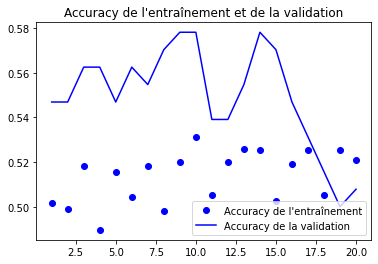

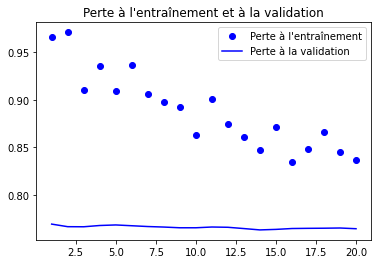

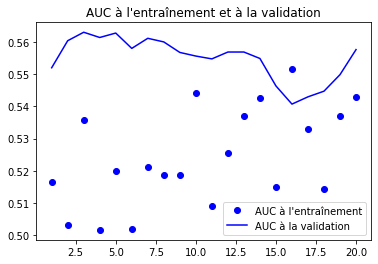

In [35]:
plot_model(history_baseline)

#### Matrice de confusion

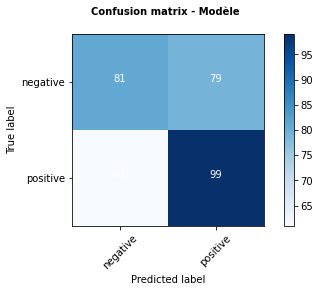

              precision    recall  f1-score   support

           0       0.57      0.51      0.54       160
           1       0.56      0.62      0.59       160

    accuracy                           0.56       320
   macro avg       0.56      0.56      0.56       320
weighted avg       0.56      0.56      0.56       320



In [36]:
plot_confusion_matrix(model_baseline, x_test, y_test)

#### Sauvegarde des résultats dans un tableau

In [37]:
# Sauvegarde des résultats
model_results = []

# Dictionnaire
model_results.append({
    'Modèle':
    'SimpleRNN + GloVe',
    'Faux positifs':
    '{:0.0f}'.format(evaluation_baseline[3]),
    'Score ROC (%)':
    '{:0.2f}'.format(evaluation_baseline[2] * 100),
    'Accuracy (%)':
    '{:0.2f}'.format(evaluation_baseline[1] * 100),
    'Perte (%)':
    '{:0.2f}'.format(evaluation_baseline[0] * 100),
    "Temps d'entrainement (s)":
    "{:0.1f}".format(fit_time)
})

# Enregistrement
model_history = pd.DataFrame.from_records(model_results)
model_history.to_csv('data/clean/resultat.csv', index=False)
model_history

,Modèle,Faux positifs,Score ROC (%),Accuracy (%),Perte (%),Temps d'entrainement (s)
0,SimpleRNN + GloVe,79,58.27,56.25,75.73,20.5


### Baseline : RNN + Glove + lemma

#### Entrainement du modèle

In [38]:
# Entrainer le modèle
start = time()
history_baseline = model_baseline.fit(x_train_lem,
                                      y_train_lem,
                                      epochs=20,
                                      batch_size=1024,
                                      validation_split=0.1,
                                      verbose=0,
                                      callbacks=[reduce_lr, callback_tensorboard])
fit_time = (time() - start)

# Sauvegarde du modèle
model_baseline.save('data/clean/simplernn_glove_lemma.h5')

#### Évaluation du modèle

In [39]:
evaluation_baseline_lem = model_baseline.evaluate(x_test_lem, y_test_lem, batch_size=1024)

1/1 [==============================] - 0s 38ms/step - loss: 0.7615 - acc: 0.5188 - auc: 0.5199 - fp: 72.0000


#### Visualisation de l'apprentissage

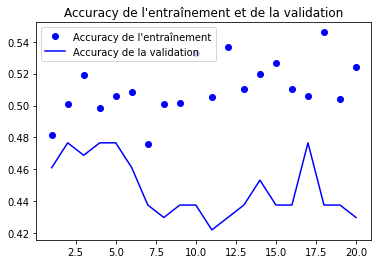

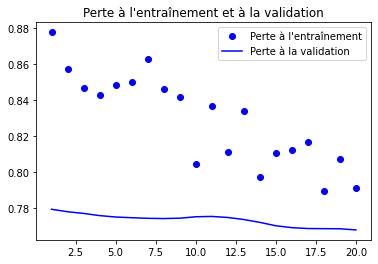

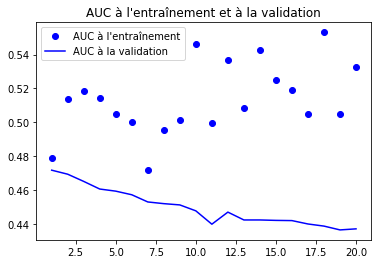

In [40]:
plot_model(history_baseline)

#### Matrice de confusion

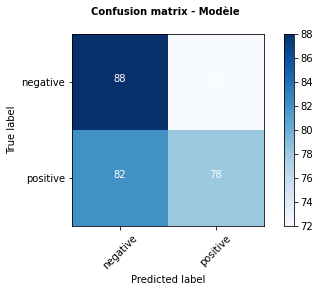

              precision    recall  f1-score   support

           0       0.52      0.55      0.53       160
           1       0.52      0.49      0.50       160

    accuracy                           0.52       320
   macro avg       0.52      0.52      0.52       320
weighted avg       0.52      0.52      0.52       320



In [41]:
plot_confusion_matrix(model_baseline, x_test_lem, y_test_lem)

#### Sauvegarde des résultats dans un tableau

In [42]:
# Dictionnaire
model_history = model_history.append(
    {
        'Modèle': 'SimpleRNN + GloVe + Lemma',
        'Faux positifs': '{:0.0f}'.format(evaluation_baseline_lem[3]),
        'Score ROC (%)': '{:0.2f}'.format(evaluation_baseline_lem[2] * 100),
        'Accuracy (%)': '{:0.2f}'.format(evaluation_baseline_lem[1] * 100),
        'Perte (%)': '{:0.2f}'.format(evaluation_baseline_lem[0] * 100),
        "Temps d'entrainement (s)": "{:0.1f}".format(fit_time)
    },
    ignore_index=True)

# Enregistrement
model_history.to_csv('data/clean/resultat.csv', index=False)
model_history

,Modèle,Faux positifs,Score ROC (%),Accuracy (%),Perte (%),Temps d'entrainement (s)
0,SimpleRNN + GloVe,79,58.27,56.25,75.73,20.5
1,SimpleRNN + GloVe + Lemma,72,51.99,51.88,76.15,7.0


In [43]:
# Sauvegarde des réusltats
model_history.to_csv('data/clean/resultat.csv', index=False)

### Baseline : RNN + Glove + stem

#### Entrainement du modèle

In [44]:
# Entrainer le modèle
start = time()
history_baseline = model_baseline.fit(x_train_stem,
                                      y_train_stem,
                                      epochs=20,
                                      batch_size=1024,
                                      validation_split=0.1,
                                      verbose=0,
                                      callbacks=[reduce_lr, callback_tensorboard])
fit_time = (time() - start)

# Sauvegarde du modèle
model_baseline.save('data/clean/simplernn_glove_stem.h5')

#### Évaluation du modèle

In [45]:
evaluation_baseline_stem = model_baseline.evaluate(x_test_stem, y_test_stem, batch_size=1024)

1/1 [==============================] - 0s 35ms/step - loss: 0.7571 - acc: 0.5219 - auc: 0.5096 - fp: 152.0000


#### Visualisation de l'apprentissage

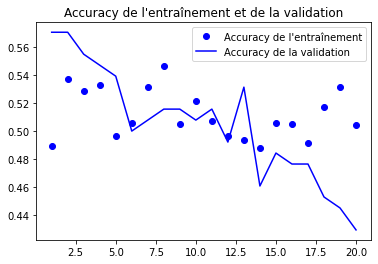

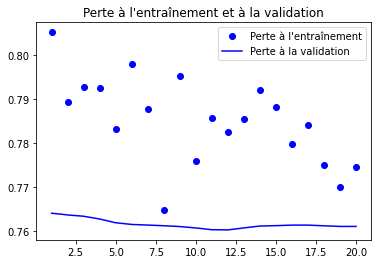

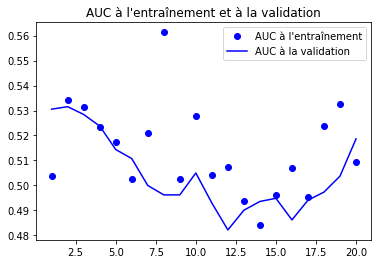

In [46]:
plot_model(history_baseline)

#### Matrice de confusion

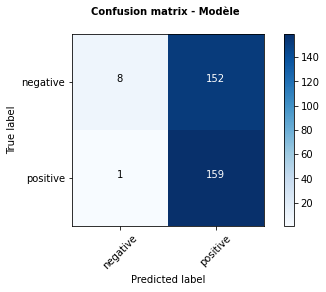

              precision    recall  f1-score   support

           0       0.89      0.05      0.09       160
           1       0.51      0.99      0.68       160

    accuracy                           0.52       320
   macro avg       0.70      0.52      0.38       320
weighted avg       0.70      0.52      0.38       320



In [47]:
plot_confusion_matrix(model_baseline, x_test_stem, y_test_stem)

#### Sauvegarde des résultats dans un tableau

In [48]:
# Dictionnaire
model_history = model_history.append(
    {
        'Modèle': 'SimpleRNN + GloVe + Stem',
        'Faux positifs': '{:0.0f}'.format(evaluation_baseline_stem[3]),
        'Score ROC (%)': '{:0.2f}'.format(evaluation_baseline_stem[2] * 100),
        'Accuracy (%)': '{:0.2f}'.format(evaluation_baseline_stem[1] * 100),
        'Perte (%)': '{:0.2f}'.format(evaluation_baseline_stem[0] * 100),
        "Temps d'entrainement (s)": "{:0.1f}".format(fit_time)
    },
    ignore_index=True)

# Enregistrement
model_history.to_csv('data/clean/resultat.csv', index=False)
model_history

,Modèle,Faux positifs,Score ROC (%),Accuracy (%),Perte (%),Temps d'entrainement (s)
0,SimpleRNN + GloVe,79,58.27,56.25,75.73,20.5
1,SimpleRNN + GloVe + Lemma,72,51.99,51.88,76.15,7.0
2,SimpleRNN + GloVe + Stem,152,50.96,52.19,75.71,8.1


## Baseline SimpleRNN + Word2Vec

### Baseline SimpleRNN + Word2Vec

#### Entrainement du modèle

In [49]:
model_baseline_w2v = Sequential()
model_baseline_w2v.add(w2v_embedding_layer)
model_baseline_w2v.add(SpatialDropout1D(0.5))
model_baseline_w2v.add(SimpleRNN(128, dropout=0.5))
model_baseline_w2v.add(Dropout(0.5))
model_baseline_w2v.add(
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_baseline_w2v.add(Dropout(0.5))
model_baseline_w2v.add(Dense(1, activation='sigmoid'))
# model_baseline_w2v.summary()

In [50]:
# Compiler le modèle
model_baseline_w2v.compile(
    loss='binary_crossentropy',
    optimizer="adam",
    metrics=['acc', 'AUC',
             tf.keras.metrics.FalsePositives(name='fp')])

# Entrainer le modèle
start = time()
history_baseline_w2v = model_baseline_w2v.fit(x_train,
                                      y_train,
                                      epochs=20,
                                      batch_size=1024,
                                      validation_split=0.1,
                                      verbose=0,
                                      callbacks=[reduce_lr,
                                                 callback_tensorboard])
fit_time = (time() - start)

# Sauvegarde du modèle
model_baseline.save('data/clean/simplernn_w2v.h5')

#### Évaluation du modèle

In [51]:
evaluation_baseline_w2v = model_baseline_w2v.evaluate(x_test, y_test, batch_size=1024)

1/1 [==============================] - 0s 51ms/step - loss: 0.7662 - acc: 0.4969 - auc: 0.4808 - fp: 38.0000


#### Visualisation de l'apprentissage

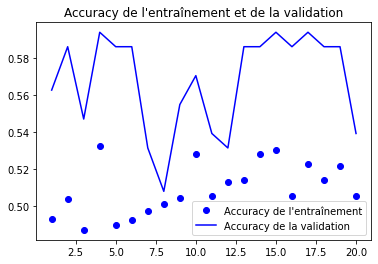

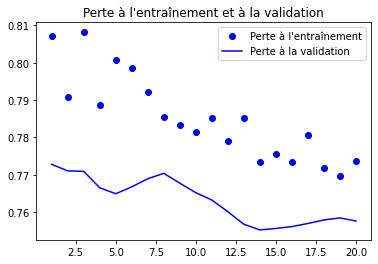

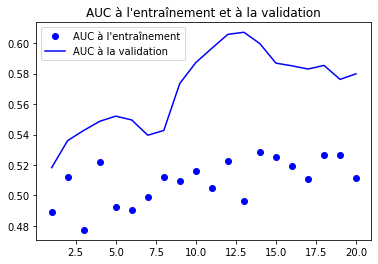

In [52]:
plot_model(history_baseline_w2v)

#### Matrice de confusion

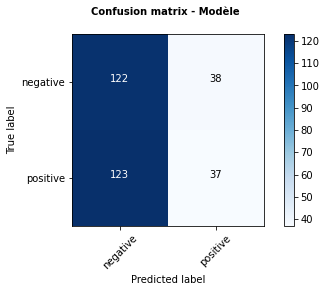

              precision    recall  f1-score   support

           0       0.50      0.76      0.60       160
           1       0.49      0.23      0.31       160

    accuracy                           0.50       320
   macro avg       0.50      0.50      0.46       320
weighted avg       0.50      0.50      0.46       320



In [53]:
plot_confusion_matrix(model_baseline_w2v, x_test, y_test)

#### Sauvegarde des résultats dans un tableau

In [54]:
# Dictionnaire
model_history = model_history.append(
    {
        'Modèle': 'SimpleRNN + W2V',
        'Faux positifs': '{:0.0f}'.format(evaluation_baseline_w2v[3]),
        'Score ROC (%)': '{:0.2f}'.format(evaluation_baseline_w2v[2] * 100),
        'Accuracy (%)': '{:0.2f}'.format(evaluation_baseline_w2v[1] * 100),
        'Perte (%)': '{:0.2f}'.format(evaluation_baseline_w2v[0] * 100),
        "Temps d'entrainement (s)": "{:0.1f}".format(fit_time)
    },
    ignore_index=True)

# Enregistrement
model_history.to_csv('data/clean/resultat.csv', index=False)
model_history

,Modèle,Faux positifs,Score ROC (%),Accuracy (%),Perte (%),Temps d'entrainement (s)
0,SimpleRNN + GloVe,79,58.27,56.25,75.73,20.5
1,SimpleRNN + GloVe + Lemma,72,51.99,51.88,76.15,7.0
2,SimpleRNN + GloVe + Stem,152,50.96,52.19,75.71,8.1
3,SimpleRNN + W2V,38,48.08,49.69,76.62,9.2


### Baseline SimpleRNN + Word2Vec + lemma

#### Entrainement du modèle

In [55]:
# Entrainer le modèle
start = time()
history_baseline_w2v_lem = model_baseline_w2v.fit(x_train_lem,
                                      y_train_lem,
                                      epochs=20,
                                      batch_size=1024,
                                      validation_split=0.1,
                                      verbose=0,
                                      callbacks=[reduce_lr,
                                                 callback_tensorboard])
fit_time = (time() - start)

# Sauvegarde du modèle
model_baseline.save('data/clean/simplernn_w2v_lem.h5')

#### Évaluation du modèle

In [56]:
evaluation_baseline_w2v_lem = model_baseline_w2v.evaluate(x_test_lem, y_test_lem, batch_size=1024)

1/1 [==============================] - 0s 37ms/step - loss: 0.7489 - acc: 0.5281 - auc: 0.5268 - fp: 41.0000


#### Visualisation de l'apprentissage

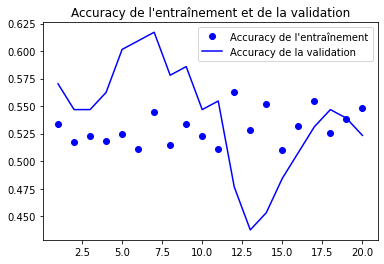

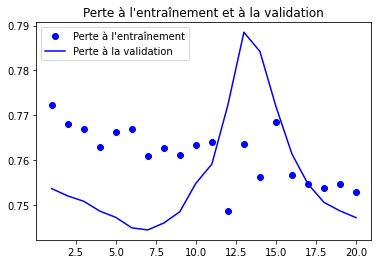

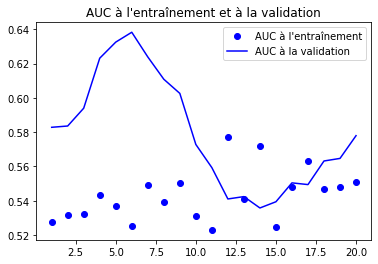

In [57]:
plot_model(history_baseline_w2v_lem)

#### Matrice de confusion

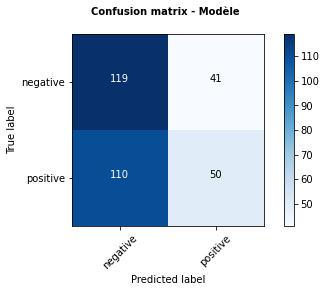

              precision    recall  f1-score   support

           0       0.52      0.74      0.61       160
           1       0.55      0.31      0.40       160

    accuracy                           0.53       320
   macro avg       0.53      0.53      0.51       320
weighted avg       0.53      0.53      0.51       320



In [58]:
plot_confusion_matrix(model_baseline_w2v, x_test_lem, y_test_lem)

#### Sauvegarde des résultats dans un tableau

In [59]:
# Dictionnaire
model_history = model_history.append(
    {
        'Modèle': 'SimpleRNN + W2V + Lemma',
        'Faux positifs': '{:0.0f}'.format(evaluation_baseline_w2v_lem[3]),
        'Score ROC (%)': '{:0.2f}'.format(evaluation_baseline_w2v_lem[2] * 100),
        'Accuracy (%)': '{:0.2f}'.format(evaluation_baseline_w2v_lem[1] * 100),
        'Perte (%)': '{:0.2f}'.format(evaluation_baseline_w2v_lem[0] * 100),
        "Temps d'entrainement (s)": "{:0.1f}".format(fit_time)
    },
    ignore_index=True)

# Enregistrement
model_history.to_csv('data/clean/resultat.csv', index=False)
model_history

,Modèle,Faux positifs,Score ROC (%),Accuracy (%),Perte (%),Temps d'entrainement (s)
0,SimpleRNN + GloVe,79,58.27,56.25,75.73,20.5
1,SimpleRNN + GloVe + Lemma,72,51.99,51.88,76.15,7.0
2,SimpleRNN + GloVe + Stem,152,50.96,52.19,75.71,8.1
3,SimpleRNN + W2V,38,48.08,49.69,76.62,9.2
4,SimpleRNN + W2V + Lemma,41,52.68,52.81,74.89,7.0


### Baseline SimpleRNN + Word2Vec + stem

#### Entrainement du modèle

In [60]:
# Entrainer le modèle
start = time()
history_baseline_w2v_stem = model_baseline_w2v.fit(x_train_stem,
                                      y_train_stem,
                                      epochs=20,
                                      batch_size=1024,
                                      validation_split=0.1,
                                      verbose=0,
                                      callbacks=[reduce_lr,
                                                 callback_tensorboard])
fit_time = (time() - start)

# Sauvegarde du modèle
model_baseline.save('data/clean/simplernn_w2v_stem.h5')

#### Évaluation du modèle

In [61]:
evaluation_baseline_w2v_stem = model_baseline_w2v.evaluate(x_test_stem, y_test_stem, batch_size=1024)

1/1 [==============================] - 0s 37ms/step - loss: 0.7443 - acc: 0.5156 - auc: 0.4965 - fp: 31.0000


#### Visualisation de l'apprentissage

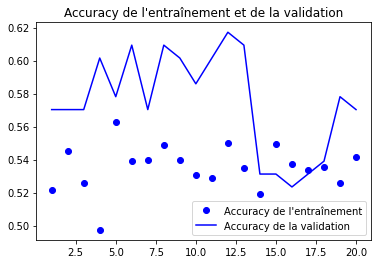

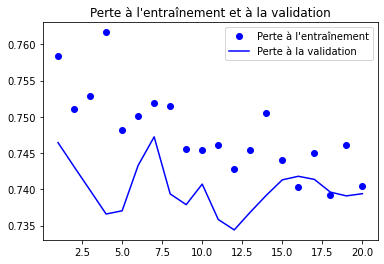

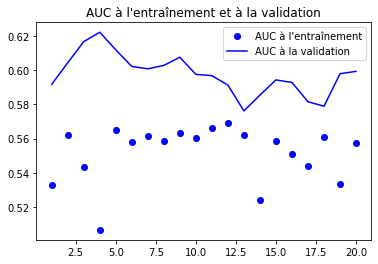

In [62]:
plot_model(history_baseline_w2v_stem)

#### Matrice de confusion

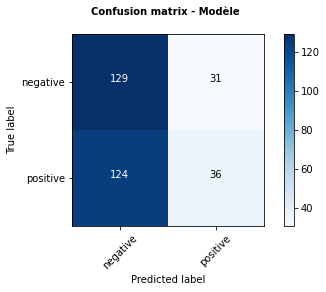

              precision    recall  f1-score   support

           0       0.51      0.81      0.62       160
           1       0.54      0.23      0.32       160

    accuracy                           0.52       320
   macro avg       0.52      0.52      0.47       320
weighted avg       0.52      0.52      0.47       320



In [63]:
plot_confusion_matrix(model_baseline_w2v, x_test_stem, y_test_stem)

#### Sauvegarde des résultats dans un tableau

In [64]:
# Dictionnaire
model_history = model_history.append(
    {
        'Modèle': 'SimpleRNN + W2V + stem',
        'Faux positifs': '{:0.0f}'.format(evaluation_baseline_w2v_stem[3]),
        'Score ROC (%)': '{:0.2f}'.format(evaluation_baseline_w2v_stem[2] * 100),
        'Accuracy (%)': '{:0.2f}'.format(evaluation_baseline_w2v_stem[1] * 100),
        'Perte (%)': '{:0.2f}'.format(evaluation_baseline_w2v_stem[0] * 100),
        "Temps d'entrainement (s)": "{:0.1f}".format(fit_time)
    },
    ignore_index=True)

# Enregistrement
model_history.to_csv('data/clean/resultat.csv', index=False)
model_history

,Modèle,Faux positifs,Score ROC (%),Accuracy (%),Perte (%),Temps d'entrainement (s)
0,SimpleRNN + GloVe,79,58.27,56.25,75.73,20.5
1,SimpleRNN + GloVe + Lemma,72,51.99,51.88,76.15,7.0
2,SimpleRNN + GloVe + Stem,152,50.96,52.19,75.71,8.1
3,SimpleRNN + W2V,38,48.08,49.69,76.62,9.2
4,SimpleRNN + W2V + Lemma,41,52.68,52.81,74.89,7.0
5,SimpleRNN + W2V + stem,31,49.65,51.56,74.43,6.2


## LSTM + Glove

<img src="data/image/machine-learning.png" width="150">

L'architecture du modèle que nous allons utiliser consiste en un modèle séquentiel avec des couches d'intégration, de suppression, de LSTM et de densité. La première couche est la couche d'intégration. Ensuite, une couche d'exclusion a été utilisée pour éviter le sur-apprentissage. Le taux pour cette couche a été fixé à 0,2.

La couche suivante est la couche LSTM, qui fonctionne avec un mécanisme connu sous le nom d'états cellulaires qui lui permet d'apprendre le contexte des mots en oubliant et en se souvenant sélectivement des choses. La configuration pour cette couche était de 200 unités et un taux d'abandon de 0,2.

Enfin, deux couches denses sont ajoutées à la dernière partie du modèle. Ces couches nous permettent de connecter complètement les unités et nous conduisent au résultat final de la classification. La première couche dense est configurée à 100 unités avec ReLU comme fonction d'activation. La deuxième couche dense, et dernière du modèle, est configurée avec 1 unité et une fonction sigmoïde afin d'obtenir un résultat de classification binaire (0 ou 1).

Le modèle utilise Adam comme algorithme d'optimisation, l'entropie croisée binaire comme fonction de perte et la précision pour mesurer la performance du modèle.

### LSTM + Glove

#### Entrainement du modèle

In [65]:
# définition du modèle
model_lstm = Sequential()
model_lstm.add(glove_embedding_layer)
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(200, dropout=0.2))
model_lstm.add(Dense(100, activation='relu'))
model_lstm.add(Dense(1, activation="sigmoid"))

print(model_lstm.summary())

model_lstm.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=['acc', 'AUC',
             tf.keras.metrics.FalsePositives(name='fp')])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 200)           749400    
                                                                 
 dropout_4 (Dropout)         (None, 35, 200)           0         
                                                                 
 lstm (LSTM)                 (None, 200)               320800    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 1,090,401
Trainable params: 341,001
Non-trainable params: 749,400
_________________________________________________________________
None


Pour améliorer les performances du modèle pendant le processus d'apprentissage, la fonction de rappel ReduceLROnPlateau est utilisée pour réduire le taux d'apprentissage d'un facteur de 0,1 lorsque la perte de validation a cessé de s'améliorer.

Le modèle a été entraîné pendant 20 époques, avec une taille de lot de 1024 et une division de validation de 0,1.

In [66]:
# modèle d'entraînement
BATCH_SIZE = 1024
EPOCHS = 30

# Entrainer le modèle
start = time()
history_lstm = model_lstm.fit(x_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=[reduce_lr, callback_tensorboard])
fit_time = (time() - start)

Epoch 1/30
2/2 [==============================] - 6s 1s/step - loss: 0.7015 - acc: 0.5122 - auc: 0.5574 - fp: 57.0000 - val_loss: 0.7395 - val_acc: 0.4297 - val_auc: 0.5820 - val_fp: 72.0000 - lr: 0.0010
Epoch 2/30
2/2 [==============================] - 0s 355ms/step - loss: 0.7018 - acc: 0.5104 - auc: 0.5669 - fp: 555.0000 - val_loss: 0.6667 - val_acc: 0.6328 - val_auc: 0.7569 - val_fp: 38.0000 - lr: 0.0010
Epoch 3/30
2/2 [==============================] - 0s 296ms/step - loss: 0.6658 - acc: 0.6311 - auc: 0.7116 - fp: 313.0000 - val_loss: 0.6288 - val_acc: 0.7031 - val_auc: 0.7944 - val_fp: 5.0000 - lr: 0.0010
Epoch 4/30
2/2 [==============================] - 0s 278ms/step - loss: 0.6499 - acc: 0.6415 - auc: 0.7676 - fp: 56.0000 - val_loss: 0.6093 - val_acc: 0.7031 - val_auc: 0.7924 - val_fp: 5.0000 - lr: 0.0010
Epoch 5/30
2/2 [==============================] - 0s 300ms/step - loss: 0.6406 - acc: 0.6467 - auc: 0.7594 - fp: 45.0000 - val_loss: 0.5919 - val_acc: 0.7266 - val_auc: 0.8022

#### Évaluation du modèle

<img src="data/image/meter.png" width="150">

Pour évaluer le modèle, nous utilisons le jeu de données de test et la même taille de BATCH_SIZE que celle utilisée lors de l'entraînement.

In [67]:
evaluation_lstm = model_lstm.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print("Perte au test : ", evaluation_lstm[0])
print("Accuracy du test:", evaluation_lstm[1])

1/1 [==============================] - 0s 42ms/step - loss: 0.6370 - acc: 0.6969 - auc: 0.7697 - fp: 64.0000
Perte au test :  0.6369991302490234
Accuracy du test: 0.6968749761581421


Une fois le modèle évalué, nous pouvons l'enregistrer afin de ne pas avoir à le réentraîner si nous l'utilisons ultérieurement pour tester de nouvelles requêtes.

In [68]:
# Sauvegarde du modèle
model_lstm.save('data/clean/lstm_glove.h5')

Nous traçons les résultats de notre modèle (accuracy et perte) pour l'entraînement et la validation, ce qui permet de vérifier plus facilement, comme c'est visuel, si le modèle est en sur- ou sous-apprentissage.

#### Visualisation de l'apprentissage

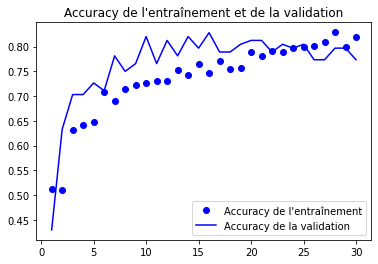

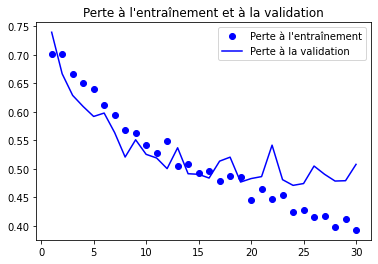

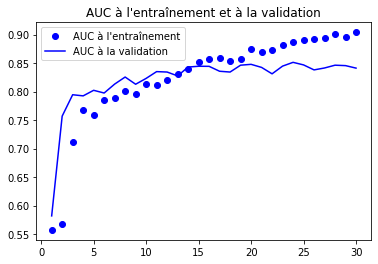

In [69]:
plot_model(history_lstm)

TODO : Rédiger une analyse des résultats

#### Matrice de confusion

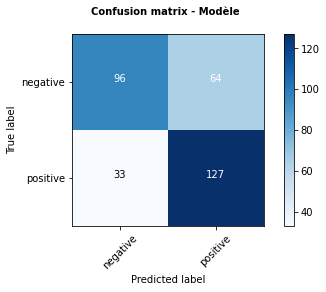

              precision    recall  f1-score   support

           0       0.74      0.60      0.66       160
           1       0.66      0.79      0.72       160

    accuracy                           0.70       320
   macro avg       0.70      0.70      0.69       320
weighted avg       0.70      0.70      0.69       320



In [70]:
plot_confusion_matrix(model_lstm, x_test, y_test)

#### Sauvegarde des résultats dans un tableau

In [71]:
# Dictionnaire
model_history = model_history.append(
    {
        'Modèle': 'LSTM + GloVe',
        'Faux positifs': '{:0.0f}'.format(evaluation_lstm[3]),
        'Score ROC (%)': '{:0.2f}'.format(evaluation_lstm[2] * 100),
        'Accuracy (%)': '{:0.2f}'.format(evaluation_lstm[1] * 100),
        'Perte (%)': '{:0.2f}'.format(evaluation_lstm[0] * 100),
        "Temps d'entrainement (s)": "{:0.1f}".format(fit_time)
    },
    ignore_index=True)

# Enregistrement
model_history.to_csv('data/clean/resultat.csv', index=False)
model_history

,Modèle,Faux positifs,Score ROC (%),Accuracy (%),Perte (%),Temps d'entrainement (s)
0,SimpleRNN + GloVe,79,58.27,56.25,75.73,20.5
1,SimpleRNN + GloVe + Lemma,72,51.99,51.88,76.15,7.0
2,SimpleRNN + GloVe + Stem,152,50.96,52.19,75.71,8.1
3,SimpleRNN + W2V,38,48.08,49.69,76.62,9.2
4,SimpleRNN + W2V + Lemma,41,52.68,52.81,74.89,7.0
5,SimpleRNN + W2V + stem,31,49.65,51.56,74.43,6.2
6,LSTM + GloVe,64,76.97,69.69,63.70,16.2


#### Prédiction du modèle

<img src="data/image/predictive-chart.png" width="150">

Comme le modèle utilise une fonction sigmoïde dans la dernière couche, cela signifie qu'il nous donne des résultats entre 0 et 1. Nous avons donc besoin d'une fonction pour décoder ces résultats. Si le résultat est inférieur à 0,5, alors le sentiment du tweet est considéré comme négatif et si le résultat est supérieur ou égal à 0,5, il est considéré comme positif.

In [72]:
# décoder la prédiction de score du modèle, pour qu'elle soit 0 ou 1
def decode_prediction(prediction):
    return 'Négatif' if prediction < 0.5 else 'Positif'

Le code présenté ci-dessous charge le modèle et le tokenizer sauvegardés dans les étapes précédentes. Et il utilise les fonctions que nous avons utilisées pour nettoyer, tokeniser et rembourrer les tweets dans l'ensemble de données d'entraînement. Ceci est important car si nous avons formé notre modèle avec des données nettoyées, nous devons également tester notre modèle avec de nouvelles données nettoyées.

In [73]:
# chargement du modèle
model_lstm = load_model('data/clean/lstm_glove.h5')
# chargement du tokéniseur
with open('data/clean/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Test du modèle avec une nouvelle requête
tweet = "I told you that she was not happy"

# nettoyage du texte de la requête
input_text = clean_text(tweet)
# tokéniser et rembourrer la requête test comme dans l'entraînement
input_text = pad_sequences(tokenizer.texts_to_sequences([input_text]),
                           maxlen=max_length)

# obtenir la prédiction du modèle
prediction = model_lstm.predict([input_text])[0]
# obtenir la prédiction de décodage
label = decode_prediction(prediction)

print(f"Tweet : {tweet}")
print(f"Score : {prediction}")
print(f"Label : {label}")

Tweet : I told you that she was not happy
Score : [0.52010226]
Label : Positif


### LSTM + Glove + lemma

#### Entrainement du modèle

In [74]:
# Entrainer le modèle
start = time()
history_lstm_lem = model_lstm.fit(x_train_lem,
                              y_train_lem,
                              batch_size=BATCH_SIZE,
                              epochs=EPOCHS,
                              validation_split=0.1,
                              verbose=0,
                              callbacks=[reduce_lr, callback_tensorboard])
fit_time = (time() - start)

# Sauvegarde du modèle
model_baseline.save('data/clean/lstm_glove_lem.h5')

#### Évaluation du modèle

In [75]:
evaluation_lstm_lem = model_lstm.evaluate(x_test_lem, y_test_lem, batch_size=1024)

1/1 [==============================] - 0s 44ms/step - loss: 0.6509 - acc: 0.6406 - auc: 0.6672 - fp: 48.0000


#### Visualisation de l'apprentissage

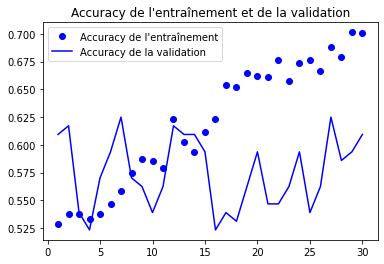

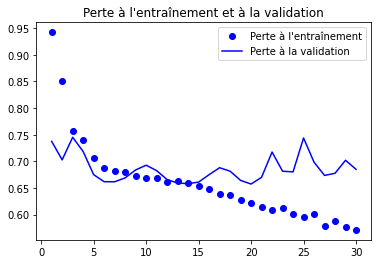

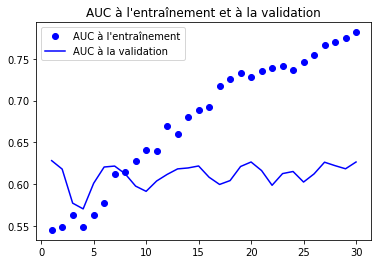

In [76]:
plot_model(history_lstm_lem)

#### Matrice de confusion

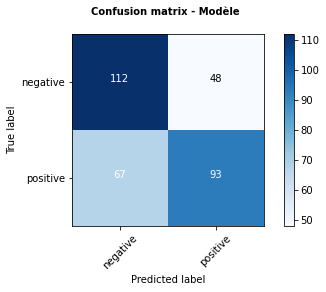

              precision    recall  f1-score   support

           0       0.63      0.70      0.66       160
           1       0.66      0.58      0.62       160

    accuracy                           0.64       320
   macro avg       0.64      0.64      0.64       320
weighted avg       0.64      0.64      0.64       320



In [77]:
plot_confusion_matrix(model_lstm, x_test_lem, y_test_lem)

#### Sauvegarde des résultats dans un tableau

In [78]:
# Dictionnaire
model_history = model_history.append(
    {
        'Modèle': 'LSTM + GloVe + Lemma',
        'Faux positifs': '{:0.0f}'.format(evaluation_lstm_lem[3]),
        'Score ROC (%)': '{:0.2f}'.format(evaluation_lstm_lem[2] * 100),
        'Accuracy (%)': '{:0.2f}'.format(evaluation_lstm_lem[1] * 100),
        'Perte (%)': '{:0.2f}'.format(evaluation_lstm_lem[0] * 100),
        "Temps d'entrainement (s)": "{:0.1f}".format(fit_time)
    },
    ignore_index=True)

# Enregistrement
model_history.to_csv('data/clean/resultat.csv', index=False)
model_history

,Modèle,Faux positifs,Score ROC (%),Accuracy (%),Perte (%),Temps d'entrainement (s)
0,SimpleRNN + GloVe,79,58.27,56.25,75.73,20.5
1,SimpleRNN + GloVe + Lemma,72,51.99,51.88,76.15,7.0
2,SimpleRNN + GloVe + Stem,152,50.96,52.19,75.71,8.1
3,SimpleRNN + W2V,38,48.08,49.69,76.62,9.2
4,SimpleRNN + W2V + Lemma,41,52.68,52.81,74.89,7.0
5,SimpleRNN + W2V + stem,31,49.65,51.56,74.43,6.2
6,LSTM + GloVe,64,76.97,69.69,63.70,16.2
7,LSTM + GloVe + Lemma,48,66.72,64.06,65.09,12.4


### LSTM + Glove + stem

#### Entrainement du modèle

In [79]:
# Entrainer le modèle
start = time()
history_lstm_stem = model_lstm.fit(x_train_stem,
                              y_train_stem,
                              batch_size=BATCH_SIZE,
                              epochs=EPOCHS,
                              validation_split=0.1,
                              verbose=0,
                              callbacks=[reduce_lr, callback_tensorboard])
fit_time = (time() - start)

# Sauvegarde du modèle
model_baseline.save('data/clean/lstm_glove_stem.h5')

#### Évaluation du modèle

In [80]:
evaluation_lstm_stem = model_lstm.evaluate(x_test_stem, y_test_stem, batch_size=1024)

1/1 [==============================] - 0s 39ms/step - loss: 0.7145 - acc: 0.5813 - auc: 0.6423 - fp: 88.0000


#### Visualisation de l'apprentissage

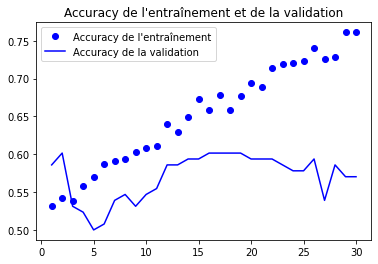

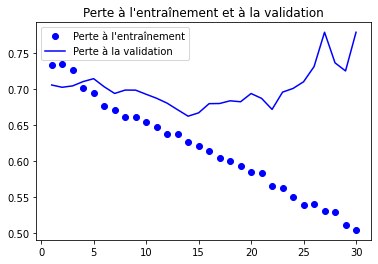

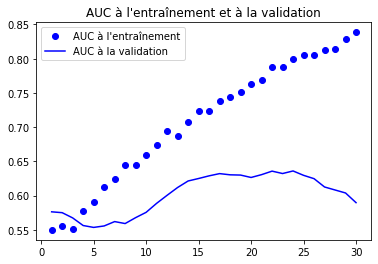

In [81]:
plot_model(history_lstm_stem)

#### Matrice de confusion

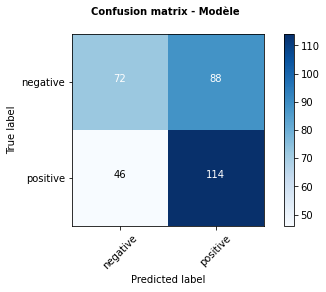

              precision    recall  f1-score   support

           0       0.61      0.45      0.52       160
           1       0.56      0.71      0.63       160

    accuracy                           0.58       320
   macro avg       0.59      0.58      0.57       320
weighted avg       0.59      0.58      0.57       320



In [82]:
plot_confusion_matrix(model_lstm, x_test_stem, y_test_stem)

#### Sauvegarde des résultats dans un tableau

In [83]:
# Dictionnaire
model_history = model_history.append(
    {
        'Modèle': 'LSTM + GloVe + Stem',
        'Faux positifs': '{:0.0f}'.format(evaluation_lstm_stem[3]),
        'Score ROC (%)': '{:0.2f}'.format(evaluation_lstm_stem[2] * 100),
        'Accuracy (%)': '{:0.2f}'.format(evaluation_lstm_stem[1] * 100),
        'Perte (%)': '{:0.2f}'.format(evaluation_lstm_stem[0] * 100),
        "Temps d'entrainement (s)": "{:0.1f}".format(fit_time)
    },
    ignore_index=True)

# Enregistrement
model_history.to_csv('data/clean/resultat.csv', index=False)
model_history

,Modèle,Faux positifs,Score ROC (%),Accuracy (%),Perte (%),Temps d'entrainement (s)
0,SimpleRNN + GloVe,79,58.27,56.25,75.73,20.5
1,SimpleRNN + GloVe + Lemma,72,51.99,51.88,76.15,7.0
2,SimpleRNN + GloVe + Stem,152,50.96,52.19,75.71,8.1
3,SimpleRNN + W2V,38,48.08,49.69,76.62,9.2
4,SimpleRNN + W2V + Lemma,41,52.68,52.81,74.89,7.0
5,SimpleRNN + W2V + stem,31,49.65,51.56,74.43,6.2
6,LSTM + GloVe,64,76.97,69.69,63.70,16.2
7,LSTM + GloVe + Lemma,48,66.72,64.06,65.09,12.4
8,LSTM + GloVe + Stem,88,64.23,58.13,71.45,10.1


## LSTM + Word2Vec

### LSTM + Word2Vec

#### Entrainement du modèle

In [84]:
# définition du modèle
model_lstm_w2v = Sequential(name='LSTM_W2V')
model_lstm_w2v.add(w2v_embedding_layer)
model_lstm_w2v.add(Dropout(0.2))
model_lstm_w2v.add(LSTM(200, dropout=0.2))
model_lstm_w2v.add(Dense(100, activation='relu'))
model_lstm_w2v.add(Dense(1, activation="sigmoid"))
# model_lstm_w2v.summary()

In [85]:
# Compiler le modèle
model_lstm_w2v.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=['acc', 'AUC',
             tf.keras.metrics.FalsePositives(name='fp')])

# Entrainer le modèle
start = time()
history_lstm_w2v = model_lstm_w2v.fit(x_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=0,
                    callbacks=[reduce_lr, callback_tensorboard])
fit_time = (time() - start)

# Sauvegarde du modèle
model_baseline.save('data/clean/lstm_w2v.h5')

#### Évaluation du modèle

In [86]:
evaluation_lstm_w2v = model_lstm_w2v.evaluate(x_test, y_test, batch_size=1024)

1/1 [==============================] - 0s 41ms/step - loss: 0.7006 - acc: 0.5125 - auc: 0.4991 - fp: 34.0000


#### Visualisation de l'apprentissage

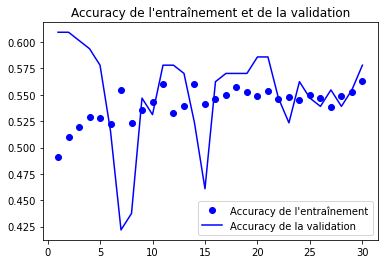

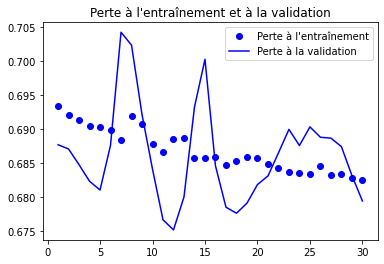

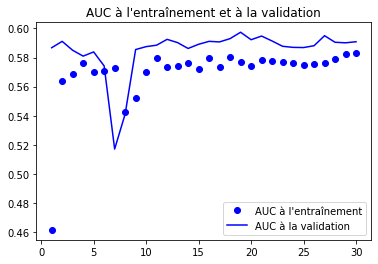

In [87]:
plot_model(history_lstm_w2v)

#### Matrice de confusion

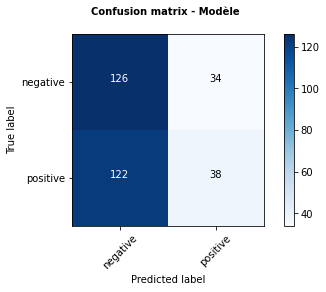

              precision    recall  f1-score   support

           0       0.51      0.79      0.62       160
           1       0.53      0.24      0.33       160

    accuracy                           0.51       320
   macro avg       0.52      0.51      0.47       320
weighted avg       0.52      0.51      0.47       320



In [88]:
plot_confusion_matrix(model_lstm_w2v, x_test, y_test)

#### Sauvegarde des résultats dans un tableau

In [89]:
# Dictionnaire
model_history = model_history.append(
    {
        'Modèle': 'LSTM + W2V',
        'Faux positifs': '{:0.0f}'.format(evaluation_lstm_w2v[3]),
        'Score ROC (%)': '{:0.2f}'.format(evaluation_lstm_w2v[2] * 100),
        'Accuracy (%)': '{:0.2f}'.format(evaluation_lstm_w2v[1] * 100),
        'Perte (%)': '{:0.2f}'.format(evaluation_lstm_w2v[0] * 100),
        "Temps d'entrainement (s)": "{:0.1f}".format(fit_time)
    },
    ignore_index=True)

# Enregistrement
model_history.to_csv('data/clean/resultat.csv', index=False)
model_history

,Modèle,Faux positifs,Score ROC (%),Accuracy (%),Perte (%),Temps d'entrainement (s)
0,SimpleRNN + GloVe,79,58.27,56.25,75.73,20.5
1,SimpleRNN + GloVe + Lemma,72,51.99,51.88,76.15,7.0
2,SimpleRNN + GloVe + Stem,152,50.96,52.19,75.71,8.1
3,SimpleRNN + W2V,38,48.08,49.69,76.62,9.2
4,SimpleRNN + W2V + Lemma,41,52.68,52.81,74.89,7.0
5,SimpleRNN + W2V + stem,31,49.65,51.56,74.43,6.2
6,LSTM + GloVe,64,76.97,69.69,63.70,16.2
7,LSTM + GloVe + Lemma,48,66.72,64.06,65.09,12.4
8,LSTM + GloVe + Stem,88,64.23,58.13,71.45,10.1
9,LSTM + W2V,34,49.91,51.25,70.06,12.3


### LSTM + Word2Vec + lemma

#### Entrainement du modèle

In [90]:
# Entrainer le modèle
start = time()
history_lstm_w2v_lem = model_lstm_w2v.fit(x_train_lem,
                    y_train_lem,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=0,
                    callbacks=[reduce_lr, callback_tensorboard])
fit_time = (time() - start)

# Sauvegarde du modèle
model_baseline.save('data/clean/lstm_w2v_lem.h5')

#### Évaluation du modèle

In [91]:
evaluation_lstm_w2v_lem = model_lstm_w2v.evaluate(x_test_lem, y_test_lem, batch_size=1024)

1/1 [==============================] - 0s 42ms/step - loss: 0.6851 - acc: 0.5469 - auc: 0.5444 - fp: 46.0000


#### Visualisation de l'apprentissage

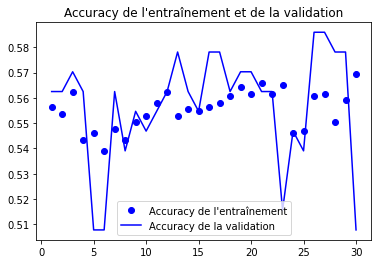

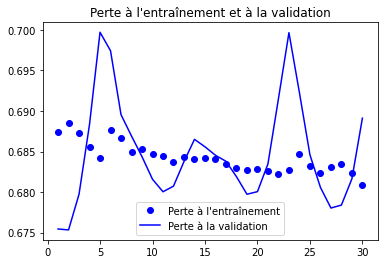

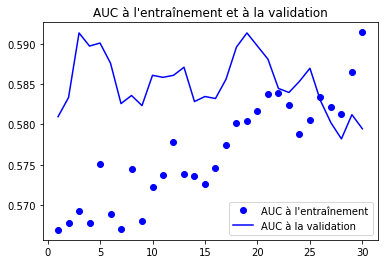

In [92]:
plot_model(history_lstm_w2v_lem)

#### Matrice de confusion

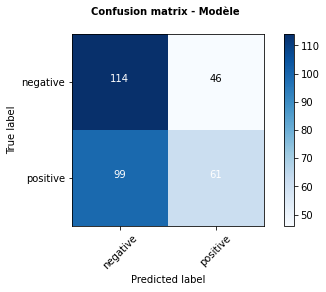

              precision    recall  f1-score   support

           0       0.54      0.71      0.61       160
           1       0.57      0.38      0.46       160

    accuracy                           0.55       320
   macro avg       0.55      0.55      0.53       320
weighted avg       0.55      0.55      0.53       320



In [93]:
plot_confusion_matrix(model_lstm_w2v, x_test_lem, y_test_lem)

#### Sauvegarde des résultats dans un tableau

In [94]:
# Dictionnaire
model_history = model_history.append(
    {
        'Modèle': 'LSTM + W2V + Lemma',
        'Faux positifs': '{:0.0f}'.format(evaluation_lstm_w2v_lem[3]),
        'Score ROC (%)': '{:0.2f}'.format(evaluation_lstm_w2v_lem[2] * 100),
        'Accuracy (%)': '{:0.2f}'.format(evaluation_lstm_w2v_lem[1] * 100),
        'Perte (%)': '{:0.2f}'.format(evaluation_lstm_w2v_lem[0] * 100),
        "Temps d'entrainement (s)": "{:0.1f}".format(fit_time)
    },
    ignore_index=True)

# Enregistrement
model_history.to_csv('data/clean/resultat.csv', index=False)
model_history

,Modèle,Faux positifs,Score ROC (%),Accuracy (%),Perte (%),Temps d'entrainement (s)
0,SimpleRNN + GloVe,79,58.27,56.25,75.73,20.5
1,SimpleRNN + GloVe + Lemma,72,51.99,51.88,76.15,7.0
2,SimpleRNN + GloVe + Stem,152,50.96,52.19,75.71,8.1
3,SimpleRNN + W2V,38,48.08,49.69,76.62,9.2
4,SimpleRNN + W2V + Lemma,41,52.68,52.81,74.89,7.0
5,SimpleRNN + W2V + stem,31,49.65,51.56,74.43,6.2
6,LSTM + GloVe,64,76.97,69.69,63.70,16.2
7,LSTM + GloVe + Lemma,48,66.72,64.06,65.09,12.4
8,LSTM + GloVe + Stem,88,64.23,58.13,71.45,10.1
9,LSTM + W2V,34,49.91,51.25,70.06,12.3


### LSTM + Word2Vec + stem

#### Entrainement du modèle

In [95]:
# Entrainer le modèle
start = time()
history_lstm_w2v_stem = model_lstm_w2v.fit(x_train_stem,
                    y_train_stem,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=0,
                    callbacks=[reduce_lr, callback_tensorboard])
fit_time = (time() - start)

# Sauvegarde du modèle
model_baseline.save('data/clean/lstm_w2v_stem.h5')

#### Évaluation du modèle

In [96]:
evaluation_lstm_w2v_stem = model_lstm_w2v.evaluate(x_test_stem, y_test_stem, batch_size=1024)

1/1 [==============================] - 0s 60ms/step - loss: 0.6960 - acc: 0.5125 - auc: 0.4990 - fp: 58.0000


#### Visualisation de l'apprentissage

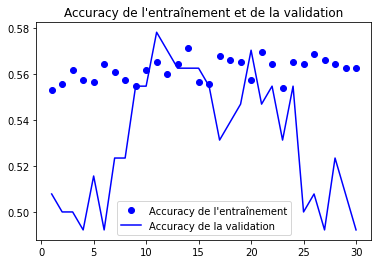

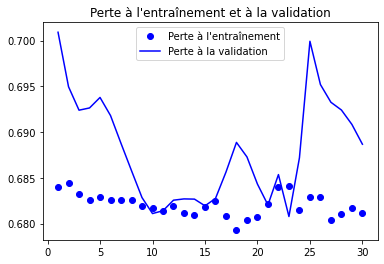

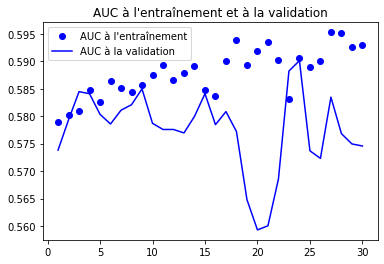

In [97]:
plot_model(history_lstm_w2v_stem)

#### Matrice de confusion

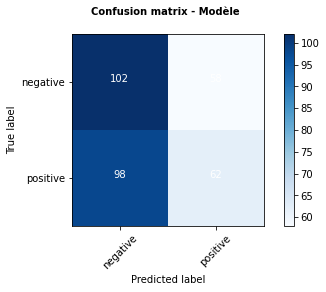

              precision    recall  f1-score   support

           0       0.51      0.64      0.57       160
           1       0.52      0.39      0.44       160

    accuracy                           0.51       320
   macro avg       0.51      0.51      0.50       320
weighted avg       0.51      0.51      0.50       320



In [98]:
plot_confusion_matrix(model_lstm_w2v, x_test_stem, y_test_stem)

#### Sauvegarde des résultats dans un tableau

In [99]:
# Dictionnaire
model_history = model_history.append(
    {
        'Modèle': 'LSTM + W2V + Stem',
        'Faux positifs': '{:0.0f}'.format(evaluation_lstm_w2v_stem[3]),
        'Score ROC (%)': '{:0.2f}'.format(evaluation_lstm_w2v_stem[2] * 100),
        'Accuracy (%)': '{:0.2f}'.format(evaluation_lstm_w2v_stem[1] * 100),
        'Perte (%)': '{:0.2f}'.format(evaluation_lstm_w2v_stem[0] * 100),
        "Temps d'entrainement (s)": "{:0.1f}".format(fit_time)
    },
    ignore_index=True)

# Enregistrement
model_history.to_csv('data/clean/resultat.csv', index=False)
model_history

,Modèle,Faux positifs,Score ROC (%),Accuracy (%),Perte (%),Temps d'entrainement (s)
0,SimpleRNN + GloVe,79,58.27,56.25,75.73,20.5
1,SimpleRNN + GloVe + Lemma,72,51.99,51.88,76.15,7.0
2,SimpleRNN + GloVe + Stem,152,50.96,52.19,75.71,8.1
3,SimpleRNN + W2V,38,48.08,49.69,76.62,9.2
4,SimpleRNN + W2V + Lemma,41,52.68,52.81,74.89,7.0
5,SimpleRNN + W2V + stem,31,49.65,51.56,74.43,6.2
6,LSTM + GloVe,64,76.97,69.69,63.70,16.2
7,LSTM + GloVe + Lemma,48,66.72,64.06,65.09,12.4
8,LSTM + GloVe + Stem,88,64.23,58.13,71.45,10.1
9,LSTM + W2V,34,49.91,51.25,70.06,12.3


## Bonus : Bidirectional LSTM

In [100]:
model_lstmbi = Sequential(name='Bidirectional_LSTM')
model_lstmbi.add(
    Embedding(input_dim=vocab_size, output_dim=256, input_length=35))
model_lstmbi.add(SpatialDropout1D(0.5))
model_lstmbi.add(Bidirectional(LSTM(128, dropout=0.5)))
model_lstmbi.add(Dropout(0.5))
model_lstmbi.add(
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_lstmbi.add(Dropout(0.5))
model_lstmbi.add(Dense(1, activation='sigmoid'))
# model_lstmbi.summary()

In [101]:
# Compiler le modèle
model_lstmbi.compile(
    loss='binary_crossentropy',
    optimizer="adam",
    metrics=['acc', 'AUC',
             tf.keras.metrics.FalsePositives(name='fp')])

# Entrainer le modèle
start = time()
history_lstmbi = model_lstmbi.fit(x_train,
                                  y_train,
                                  epochs=20,
                                  batch_size=1024,
                                  validation_split=0.1,
                                  verbose=0,
                                  callbacks=[reduce_lr, callback_tensorboard])
fit_time = (time() - start)

In [102]:
evaluation_lstmbi = model_lstmbi.evaluate(x_test, y_test, batch_size=1024)

1/1 [==============================] - 0s 36ms/step - loss: 0.6657 - acc: 0.6406 - auc: 0.7323 - fp: 72.0000


In [103]:
# Dictionnaire
model_history = model_history.append(
    {
        'Modèle': 'Bidirectional LSTM',
        'Faux positifs': '{:0.0f}'.format(evaluation_lstmbi[3]),
        'Score ROC (%)': '{:0.2f}'.format(evaluation_lstmbi[2] * 100),
        'Accuracy (%)': '{:0.2f}'.format(evaluation_lstmbi[1] * 100),
        'Perte (%)': '{:0.2f}'.format(evaluation_lstmbi[0] * 100),
        "Temps d'entrainement (s)": "{:0.1f}".format(fit_time)
    },
    ignore_index=True)

# Enregistrement
model_history

,Modèle,Faux positifs,Score ROC (%),Accuracy (%),Perte (%),Temps d'entrainement (s)
0,SimpleRNN + GloVe,79,58.27,56.25,75.73,20.5
1,SimpleRNN + GloVe + Lemma,72,51.99,51.88,76.15,7.0
2,SimpleRNN + GloVe + Stem,152,50.96,52.19,75.71,8.1
3,SimpleRNN + W2V,38,48.08,49.69,76.62,9.2
4,SimpleRNN + W2V + Lemma,41,52.68,52.81,74.89,7.0
5,SimpleRNN + W2V + stem,31,49.65,51.56,74.43,6.2
6,LSTM + GloVe,64,76.97,69.69,63.70,16.2
7,LSTM + GloVe + Lemma,48,66.72,64.06,65.09,12.4
8,LSTM + GloVe + Stem,88,64.23,58.13,71.45,10.1
9,LSTM + W2V,34,49.91,51.25,70.06,12.3


## BERT

### Entrainement du modèle

In [104]:
logging.set_verbosity_error()
tokenizer_bert = AutoTokenizer.from_pretrained("bert-base-cased")
bert = TFAutoModel.from_pretrained("bert-base-cased")

In [105]:
X_test_bert = test_data["text"].values
y_test_bert = test_data["target"].values

X_train_bert = train_data["text"].values
y_train_bert = train_data["target"].values

In [106]:
df_train_bert = bertify_data(X_train_bert, y_train_bert)
df_test_bert = bertify_data(X_test_bert, y_test_bert)

In [107]:
model_bert = Sequential(name='Bert')

input_ids = tf.keras.layers.Input(shape=(128, ),
                                  name='input_ids',
                                  dtype='int32')
attention_mask = tf.keras.layers.Input(shape=(128, ),
                                       name='attention_mask',
                                       dtype='int32')

embedding_bert = bert(input_ids, attention_mask=attention_mask)[0]

X_bert = tf.keras.layers.GlobalMaxPool1D()(embedding_bert)
X_bert = tf.keras.layers.BatchNormalization()(X_bert)
X_bert = tf.keras.layers.Dense(128, activation='relu')(X_bert)
X_bert = tf.keras.layers.Dropout(0.1)(X_bert)
y_bert = tf.keras.layers.Dense(2, activation='softmax', name='outputs')(X_bert)

model_bert = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=y_bert)

model_bert.layers[2].trainable = False

# model_bert.summary()

In [108]:
# Compiler le modèle
model_bert.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['acc', 'AUC',
             tf.keras.metrics.FalsePositives(name='fp')])

# Entrainer le modèle
start = time()
history_bert = model_bert.fit(df_train_bert,
                              epochs=1,
                              verbose=0)
fit_time = (time() - start)

### Évaluation du modèle

In [109]:
evaluation_bert = model_bert.evaluate(df_test_bert)

10/10 [==============================] - 10s 641ms/step - loss: 0.6148 - acc: 0.6812 - auc: 0.7517 - fp: 102.0000


### Sauvegarde des résultats dans un tableau

In [110]:
# Dictionnaire
model_history = model_history.append(
    {
        'Modèle': 'Bert',
        'Faux positifs': '{:0.0f}'.format(evaluation_bert[3]),
        'Score ROC (%)': '{:0.2f}'.format(evaluation_bert[2] * 100),
        'Accuracy (%)': '{:0.2f}'.format(evaluation_bert[1] * 100),
        'Perte (%)': '{:0.2f}'.format(evaluation_bert[0] * 100),
        "Temps d'entrainement (s)": "{:0.1f}".format(fit_time)
    },
    ignore_index=True)

# Enregistrement
model_history.to_csv('data/clean/resultat.csv', index=False)
model_history

,Modèle,Faux positifs,Score ROC (%),Accuracy (%),Perte (%),Temps d'entrainement (s)
0,SimpleRNN + GloVe,79,58.27,56.25,75.73,20.5
1,SimpleRNN + GloVe + Lemma,72,51.99,51.88,76.15,7.0
2,SimpleRNN + GloVe + Stem,152,50.96,52.19,75.71,8.1
3,SimpleRNN + W2V,38,48.08,49.69,76.62,9.2
4,SimpleRNN + W2V + Lemma,41,52.68,52.81,74.89,7.0
5,SimpleRNN + W2V + stem,31,49.65,51.56,74.43,6.2
6,LSTM + GloVe,64,76.97,69.69,63.70,16.2
7,LSTM + GloVe + Lemma,48,66.72,64.06,65.09,12.4
8,LSTM + GloVe + Stem,88,64.23,58.13,71.45,10.1
9,LSTM + W2V,34,49.91,51.25,70.06,12.3


## BERT + LSTM

In [111]:
X_bert = tf.keras.layers.LSTM(200, dropout=0.2)(embedding_bert)
X_bert = tf.keras.layers.Dropout(0.2)(X_bert)
y_bert = tf.keras.layers.Dense(2, activation='softmax', name='outputs')(X_bert)

model_bert_lstm = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=y_bert)

model_bert_lstm.layers[2].trainable = False

# model_bert_lstm.summary()

In [112]:
# Compiler le modèle
model_bert_lstm.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['acc', 'AUC',
             tf.keras.metrics.FalsePositives(name='fp')])

# Entrainer le modèle
start = time()
history_bert_lstm = model_bert_lstm.fit(df_train_bert,
                              epochs=1,
                              verbose=0)
fit_time = (time() - start)

### Évaluation du modèle

In [113]:
evaluation_bert_lstm = model_bert_lstm.evaluate(df_test_bert)

10/10 [==============================] - 8s 297ms/step - loss: 0.5774 - acc: 0.6812 - auc: 0.7658 - fp: 102.0000


### Sauvegarde des résultats dans un tableau

In [114]:
# Dictionnaire
model_history = model_history.append(
    {
        'Modèle': 'Bert + LSTM',
        'Faux positifs': '{:0.0f}'.format(evaluation_bert_lstm[3]),
        'Score ROC (%)': '{:0.2f}'.format(evaluation_bert_lstm[2] * 100),
        'Accuracy (%)': '{:0.2f}'.format(evaluation_bert_lstm[1] * 100),
        'Perte (%)': '{:0.2f}'.format(evaluation_bert_lstm[0] * 100),
        "Temps d'entrainement (s)": "{:0.1f}".format(fit_time)
    },
    ignore_index=True)

# Enregistrement
model_history.to_csv('data/clean/resultat.csv', index=False)
model_history

,Modèle,Faux positifs,Score ROC (%),Accuracy (%),Perte (%),Temps d'entrainement (s)
0,SimpleRNN + GloVe,79,58.27,56.25,75.73,20.5
1,SimpleRNN + GloVe + Lemma,72,51.99,51.88,76.15,7.0
2,SimpleRNN + GloVe + Stem,152,50.96,52.19,75.71,8.1
3,SimpleRNN + W2V,38,48.08,49.69,76.62,9.2
4,SimpleRNN + W2V + Lemma,41,52.68,52.81,74.89,7.0
5,SimpleRNN + W2V + stem,31,49.65,51.56,74.43,6.2
6,LSTM + GloVe,64,76.97,69.69,63.70,16.2
7,LSTM + GloVe + Lemma,48,66.72,64.06,65.09,12.4
8,LSTM + GloVe + Stem,88,64.23,58.13,71.45,10.1
9,LSTM + W2V,34,49.91,51.25,70.06,12.3


## TensorBoard

In [115]:
%tensorboard --logdir data/logs

Reusing TensorBoard on port 6006 (pid 22588), started 7:31:37 ago. (Use '!kill 22588' to kill it.)

## Tableau comparatif

<AxesSubplot:ylabel='Modèle'>

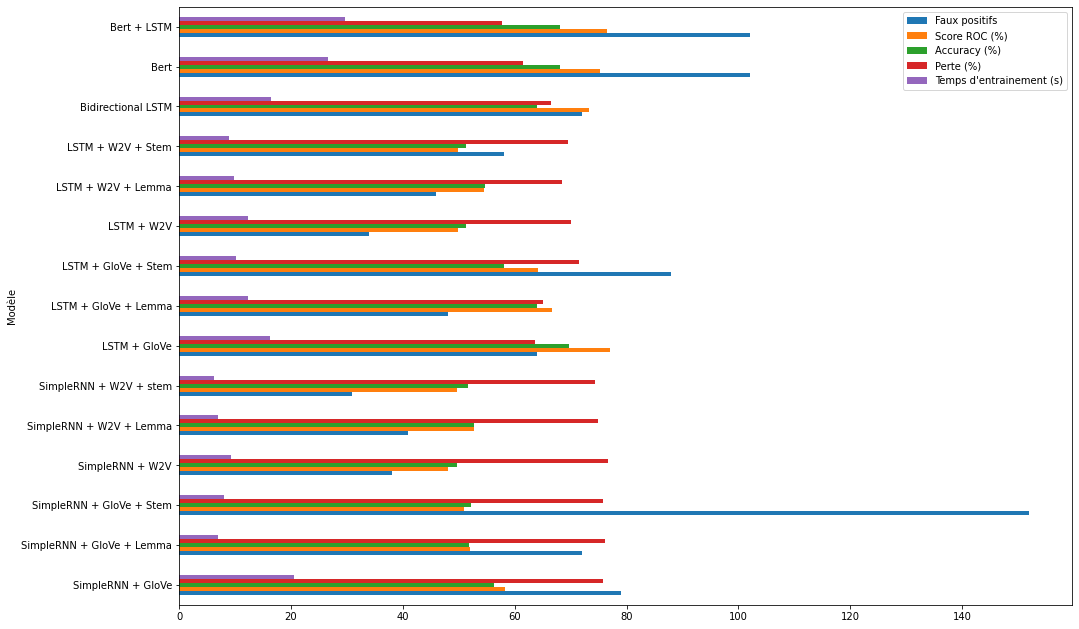

In [116]:
# Import Data
df = pd.read_csv("data/clean/resultat.csv")

df.plot.barh(x='Modèle', figsize=(16,11))

## Conclusions

<img src="data/image/light-bulb.png" width="150">

L'analyse des sentiments n'est pas une tâche facile, comme c'est le cas pour le traitement du langage naturel. Les tweets ont tendance à être bruités et à utiliser de nombreuses formes différentes pour les mots, ce qui peut constituer un problème pour leur analyse. Cependant, la quantité de données et le prétraitement des données ont beaucoup aidé ce projet à obtenir de bons résultats.

Le embedding pré-entraînée semble être une décision importante car elle a montré de meilleurs résultats lorsqu'elle a été pré-entraînée spécialement avec des tweets qu'avec des articles de Wikipedia.

Les prédictions obtenues avec les nouvelles données sont précises par rapport au contenu des tweets, ce qui signifie que le modèle fonctionne bien avec une précision de ~77%.

Le modèle pourrait être amélioré en ajoutant de nouvelles techniques de prétraitement des données et avec d'autres architectures de modèles recommandées pour l'analyse des sentiments comme les LSTM bidirectionnels.